In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
!ls  gdrive/MyDrive/Brain_Tumor

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
ls: cannot access 'gdrive/MyDrive/Brain_Tumor': No such file or directory


In [ ]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
import shutil

# Define paths
source_dir = "/content/gdrive/MyDrive/mini_project_shira_and_tzfiya/Brain_Tumor/Training"  # Update with your actual path

# Output path: current directory
output_dir = "./brain_tumor_dataset"

# Number of images per class for each set
split_counts = {
    'Training': 100,
    'Validation': 50,
    'Testing': 50
}

# Target classes
classes = ["glioma_tumor", "meningioma_tumor"]

def is_image_file(filename):
    return filename.lower().endswith(('.jpg', '.jpeg', '.png'))

def prepare_split_data():
    # Create split folders
    for split in split_counts:
        for cls in classes:
            os.makedirs(os.path.join(output_dir, split, cls), exist_ok=True)

    for cls in classes:
        class_path = os.path.join(source_dir, cls)
        all_images = [f for f in os.listdir(class_path) if is_image_file(f)]
        random.shuffle(all_images)

        total_needed = sum(split_counts.values())
        selected_images = all_images[:total_needed]

        start = 0
        for split, count in split_counts.items():
            split_images = selected_images[start:start+count]
            for img in split_images:
                src = os.path.join(class_path, img)
                dst = os.path.join(output_dir, split, cls, img)
                try:
                    shutil.copyfile(src, dst)
                except Exception as e:
                    print(f"⚠️ Skipping {img} due to error: {e}")
            start += count

    print("\n✅ Dataset split complete.")
    print(f"Split folders created inside: {os.path.abspath(output_dir)}")

# Run
prepare_split_data()



✅ Dataset split complete.
Split folders created inside: /content/brain_tumor_dataset


In [ ]:
%cd "/content/brain_tumor_dataset"

/content/brain_tumor_dataset


In [ ]:
!ls

brain_tumor_dataset	      saved_models_20250603_131115  Training
cnn_model_imbalanced.h5       siamese_model.h5		    Validation
imbalanced_dataset	      siamese_model_imbalanced.h5
saved_models_20250603_120618  Testing


In [ ]:
!ls /content/gdrive/MyDrive/mini_project_shira_and_tzfiya/Brain_Tumor/Testing

glioma_tumor  meningioma_tumor	no_tumor  pituitary_tumor


Found 848 images belonging to 2 classes.
Found 469 images belonging to 2 classes.
Found 477 images belonging to 2 classes.
Loaded 848 images.
Loaded 469 images.
Loaded 477 images.


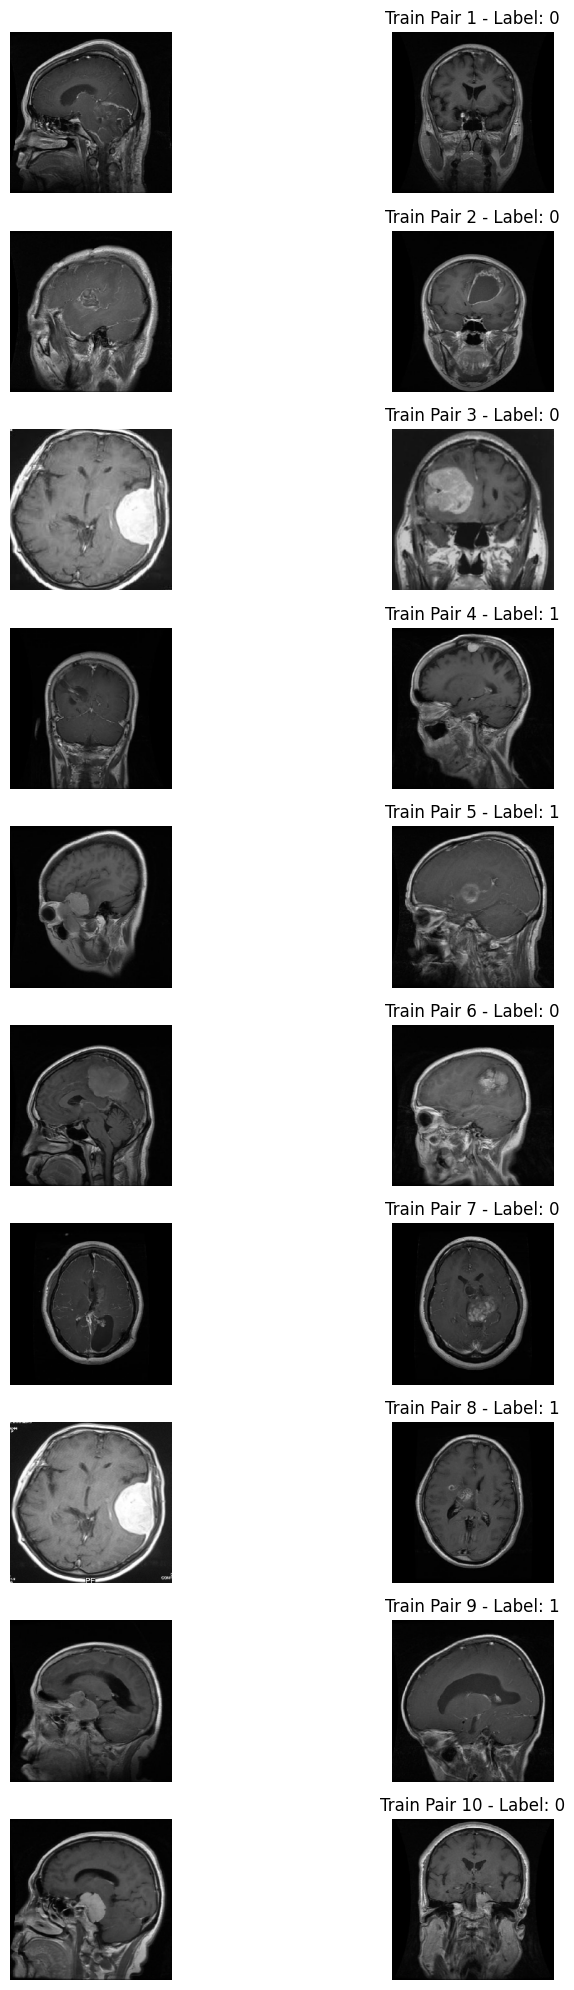

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

class SiamesePairGenerator(tf.keras.utils.Sequence):
    def __init__(self, base_generator, batch_size=32):
        self.batch_size = batch_size
        self.base_generator = base_generator
        self.x, self.y = self._load_data()
        self.label_to_indices = {label: np.where(self.y == label)[0] for label in np.unique(self.y)}

    def _load_data(self):
        x, y = [], []
        self.base_generator.reset()
        for _ in range(len(self.base_generator)):
            xi, yi = next(self.base_generator)
            x.append(xi)
            y.append(yi)
        x = np.concatenate(x)
        y = np.concatenate(y)
        print(f"Loaded {len(x)} images.")
        return x, y

    def __len__(self):
        return max(1, len(self.x) // self.batch_size)

    def __getitem__(self, idx):
        left, right, labels = [], [], []

        for _ in range(self.batch_size):
            if np.random.rand() < 0.5:
                cls = np.random.choice(list(self.label_to_indices.keys()))
                i1, i2 = np.random.choice(self.label_to_indices[cls], 2, replace=False)
                labels.append(0)
            else:
                cls1, cls2 = np.random.choice(list(self.label_to_indices.keys()), 2, replace=False)
                i1 = np.random.choice(self.label_to_indices[cls1])
                i2 = np.random.choice(self.label_to_indices[cls2])
                labels.append(1)
            left.append(self.x[i1])
            right.append(self.x[i2])

        return (np.array(left), np.array(right)), np.array(labels)

def visualize(p1, p2, labels, title):
    plt.figure(figsize=(10, 20))
    for i in range(10):
        plt.subplot(10, 2, 2*i+1)
        plt.imshow(p1[i]); plt.axis('off')
        plt.subplot(10, 2, 2*i+2)
        plt.imshow(p2[i]); plt.axis('off')
        plt.title(f'{title} Pair {i+1} - Label: {labels[i]}')
    plt.tight_layout(); plt.show()

if __name__ == "__main__":
    train_dir = './Training'  # <-- must have subfolders per class!
    val_dir = './Validation'
    test_dir = './Testing'

    datagen = ImageDataGenerator(rescale=1./255)
    img_size = (224, 224)

    base_train = datagen.flow_from_directory(
        train_dir, target_size=img_size, batch_size=50, class_mode='binary', shuffle=True)
    base_val = datagen.flow_from_directory(
        val_dir, target_size=img_size, batch_size=50, class_mode='binary', shuffle=False)
    base_test = datagen.flow_from_directory(
        test_dir, target_size=img_size, batch_size=50, class_mode='binary', shuffle=False)

    train_gen = SiamesePairGenerator(base_train, batch_size=32)
    val_gen = SiamesePairGenerator(base_val, batch_size=32)
    test_gen= SiamesePairGenerator(base_test, batch_size=32)

    # Test: fetch first batch
    (x1, x2), y = train_gen[0]
    visualize(x1, x2, y, title='Train')

Loaded 848 images.
Loaded 469 images.


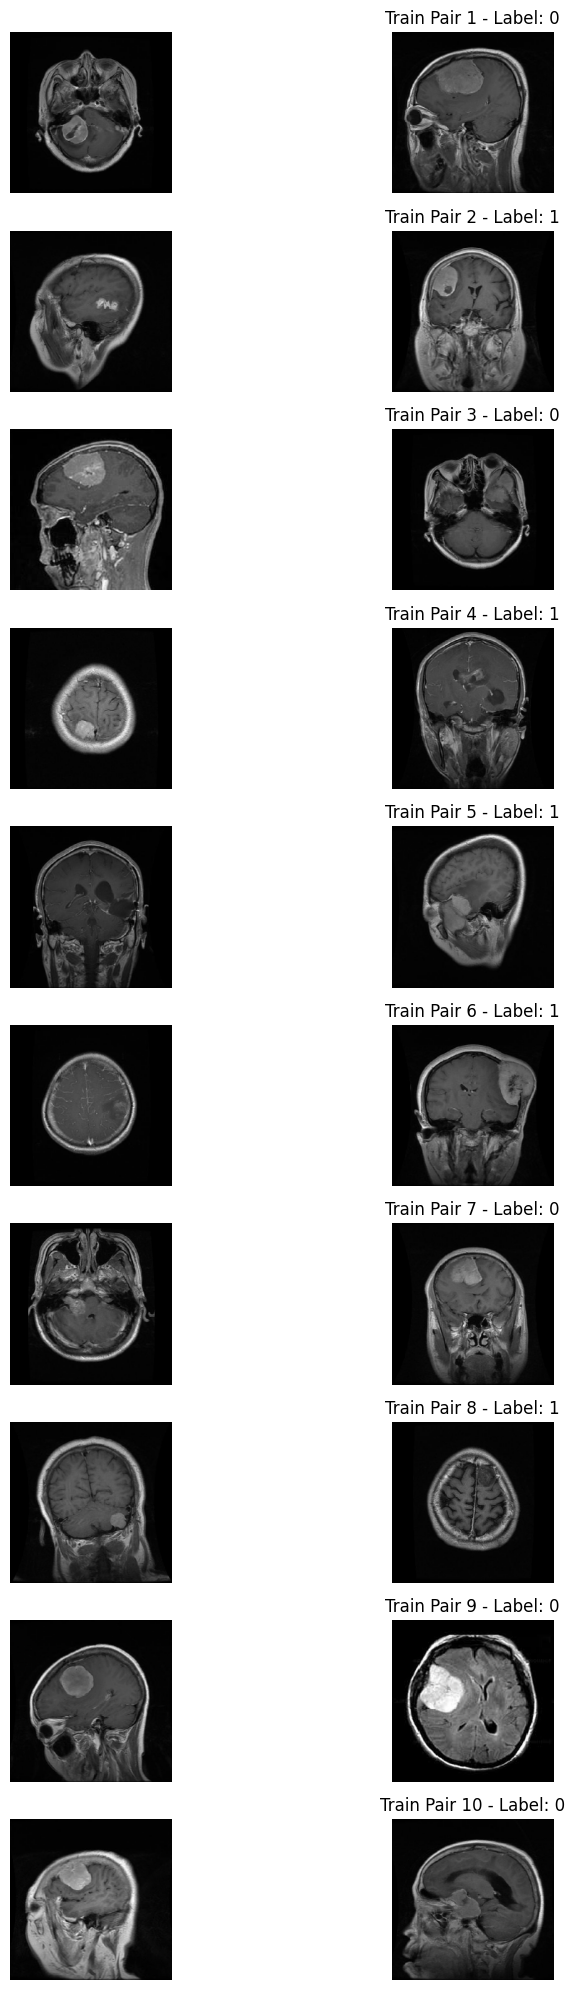

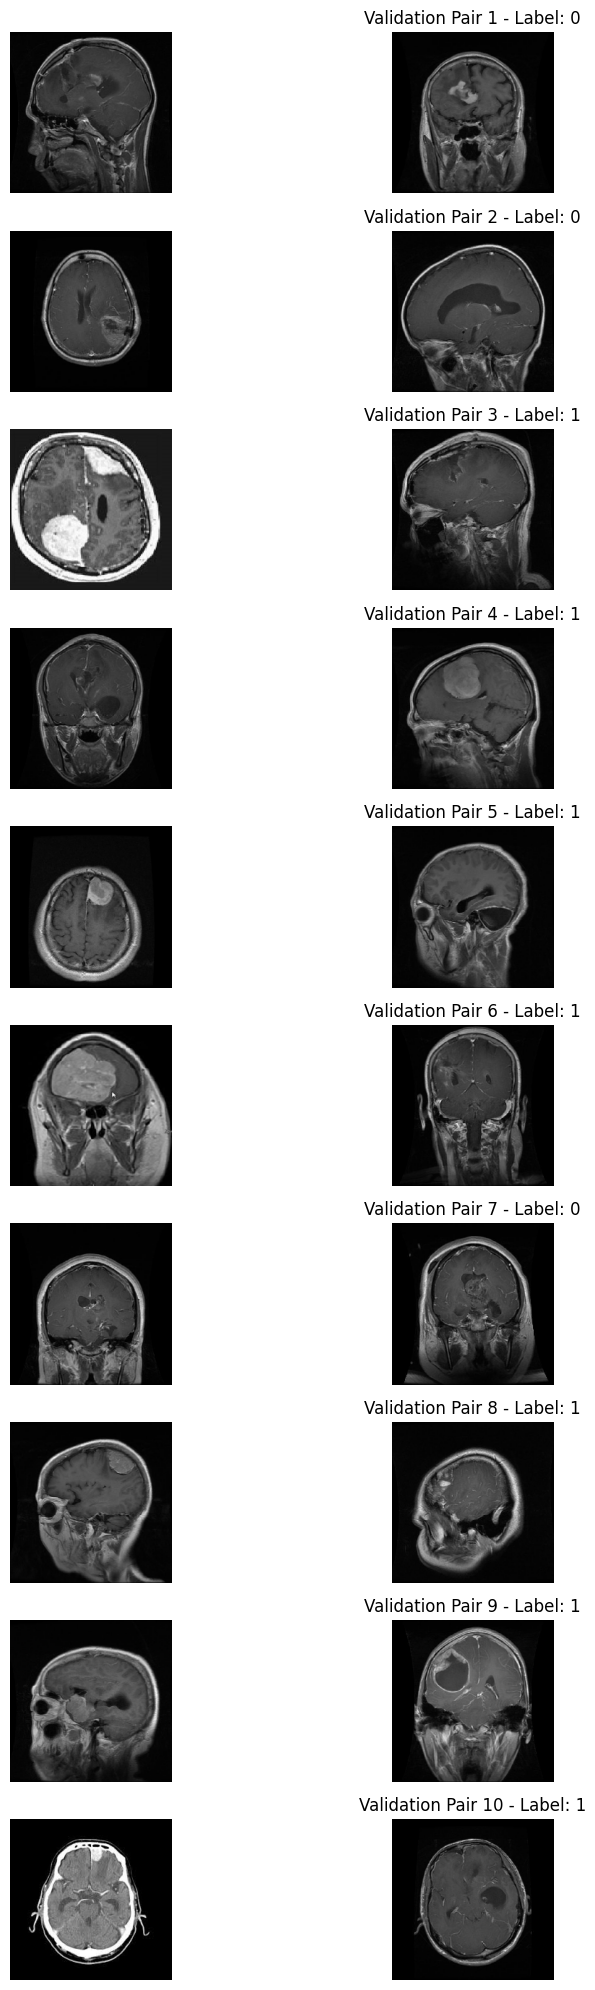

In [ ]:
train_gen = SiamesePairGenerator(base_train, batch_size=32)
val_gen = SiamesePairGenerator(base_val, batch_size=32)


    # Example usage: one batch
(train_left, train_right), train_labels = train_gen[0]
(val_left, val_right), val_labels = val_gen[0]

    # Visualize 10 training and validation pairs
visualize(train_left, train_right, train_labels, title='Train')
visualize(val_left, val_right, val_labels, title='Validation')

In [ ]:
# Define a Siamese network with DenseNet121 as the base model
def build_siamese_network(input_shape):
    # Load pre-trained DenseNet121 with ImageNet weights
    base_model = DenseNet121(
        weights='imagenet',
        include_top=False,
        input_shape=input_shape
    )

    # Freeze the pre-trained layers except for the last 20 layers
    for layer in base_model.layers[:-20]:
        layer.trainable = False

    # Add custom layers on top of DenseNet121
    input = keras.layers.Input(input_shape)
    x = base_model(input)

    # Global pooling to reduce dimensions
    x = keras.layers.GlobalAveragePooling2D()(x)

    # Additional dense layers for feature extraction
    x = keras.layers.Dense(512, activation="relu")(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Dropout(0.2)(x)
    x = keras.layers.Dense(128, activation="relu")(x)

    return keras.Model(input, x)

# Define contrastive loss function
def contrastive_loss(margin=1.0):
    def loss(y_true, y_pred):
        square_pred = tf.square(y_pred)
        margin_square = tf.square(tf.maximum(margin - y_pred, 0))
        return tf.reduce_mean((1 - y_true) * square_pred + (y_true) * margin_square)
    return loss

# Euclidean Distance Function
def euclidean_distance(vects):
    x, y = vects
    sum_square = tf.reduce_sum(tf.square(x - y), axis=1, keepdims=True)
    return tf.sqrt(tf.maximum(sum_square, keras.backend.epsilon()))

def compute_contrastive_accuracy(y_true, y_pred, threshold=0.5):
    return tf.keras.metrics.binary_accuracy(y_true, tf.cast(y_pred > threshold, tf.float32))


# Create the Siamese model using DenseNet121
input_shape = (224, 224, 3)  # Standard input size for DenseNet121
embedding_network = build_siamese_network(input_shape)

input_1 = keras.layers.Input(input_shape)
input_2 = keras.layers.Input(input_shape)

tower_1 = embedding_network(input_1)
tower_2 = embedding_network(input_2)

merge_layer = keras.layers.Lambda(euclidean_distance, output_shape=(1,))([tower_1, tower_2])
normal_layer = keras.layers.BatchNormalization()(merge_layer)
output_layer = keras.layers.Dense(1, activation="sigmoid")(normal_layer)

siamese_network = keras.Model(inputs=[input_1, input_2], outputs=output_layer)

siamese_network.compile(loss=contrastive_loss(margin=1.5), optimizer=keras.optimizers.Adam(learning_rate=1e-3), metrics=[compute_contrastive_accuracy])
siamese_network.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_3       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional          │ (None, 128)       │  7,630,016 │ input_layer_2[0]… │
│ (Functional)        │                   │            │ input_layer_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 1)         │          0 │ functional[0][0], │
│                     │                   │            │ functional[1][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1)         │          4 │ lambda[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 1)         │          2 │ batch_normalizat… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 7,630,022 (29.11 MB)

 Trainable params: 958,660 (3.66 MB)

 Non-trainable params: 6,671,362 (25.45 MB)

In [ ]:
# Callback to log distances in the desired format
class DistanceLogger(tf.keras.callbacks.Callback):
    def __init__(self, validation_generator, num_batches=None):
        """
        Initialize with a validation generator instead of raw data

        Args:
            validation_generator: The validation data generator
            num_batches: Number of batches to use for validation (default: all)
        """
        super().__init__()
        self.validation_generator = validation_generator
        self.num_batches = num_batches if num_batches is not None else len(validation_generator)

    def on_epoch_end(self, epoch, logs=None):
        # Initialize arrays to store predictions and labels
        all_distances = []
        all_labels = []

        # Collect predictions from validation generator
        for i in range(min(self.num_batches, len(self.validation_generator))):
            # Get batch from generator
            (x1_batch, x2_batch), y_batch = self.validation_generator[i]

            # Get distances for this batch
            distances = self.model.predict([x1_batch, x2_batch], verbose=0)

            # Append to our collections
            all_distances.extend(distances)
            all_labels.extend(y_batch)

        # Convert to numpy arrays
        all_distances = np.array(all_distances).flatten()
        all_labels = np.array(all_labels)

        # Calculate metrics (remember: 0=same class, 1=different class)
        val_pos_dist = all_distances[all_labels == 0].mean()
        val_neg_dist = all_distances[all_labels == 1].mean()
        distance_gap = val_neg_dist - val_pos_dist

        # Print in the desired format
        print(f"Validation Set - Avg distance (same): {val_pos_dist:.4f}")
        print(f"Validation Set - Avg distance (diff): {val_neg_dist:.4f}")
        print(f"Distance gap: {distance_gap:.4f}")

        # Save metrics for later visualization
        if not hasattr(self, 'history'):
            self.history = {
                'val_pos_dist': [],
                'val_neg_dist': [],
                'distance_gap': []
            }

        self.history['val_pos_dist'].append(val_pos_dist)
        self.history['val_neg_dist'].append(val_neg_dist)
        self.history['distance_gap'].append(distance_gap)


# Import the necessary libraries
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from tensorflow.keras.callbacks import Callback

class EmbeddingVisualizer(Callback):
    """
    Callback to visualize the embedding space after each epoch using data from a generator.
    """
    def __init__(self, validation_generator, embedding_network, num_samples=500, class_names=None):
        """
        Initialize the visualizer with a validation generator.

        Args:
            validation_generator: SiamesePairGenerator to get validation samples from
            embedding_network: Model that extracts embeddings
            num_samples: Maximum number of samples to plot
            class_names: List of class names (from base_generator.class_indices)
        """
        super().__init__()
        self.validation_generator = validation_generator
        self.embedding_network = embedding_network
        self.num_samples = min(num_samples, len(validation_generator) * validation_generator.batch_size)
        self.class_names = class_names

        # For collecting history
        self.embeddings_history = []
        self.figures = []

        # Cache data for visualization
        self.cached_data = self._cache_data()

    def _cache_data(self):
        """Cache a subset of the validation data for visualization"""
        x1_samples, x2_samples, labels = [], [], []
        samples_collected = 0
        batch_index = 0

        # Collect samples until we reach desired number
        while samples_collected < self.num_samples and batch_index < len(self.validation_generator):
            # Get batch from generator
            (x1_batch, x2_batch), y_batch = self.validation_generator[batch_index]

            # Determine how many samples to take from this batch
            samples_to_take = min(len(y_batch), self.num_samples - samples_collected)

            # Add samples to our collections
            x1_samples.append(x1_batch[:samples_to_take])
            x2_samples.append(x2_batch[:samples_to_take])
            labels.append(y_batch[:samples_to_take])

            # Update counters
            samples_collected += samples_to_take
            batch_index += 1

        # Combine all batches
        x1_all = np.vstack(x1_samples)
        x2_all = np.vstack(x2_samples)
        labels_all = np.concatenate(labels)

        print(f"Cached {len(labels_all)} samples for embedding visualization")
        return x1_all, x2_all, labels_all

    def on_epoch_end(self, epoch, logs=None):
        # Get cached data
        x1_all, x2_all, labels_all = self.cached_data

        # Extract embeddings using the embedding network
        embeddings_1 = self.embedding_network.predict(x1_all, verbose=0)
        embeddings_2 = self.embedding_network.predict(x2_all, verbose=0)

        # Apply PCA to reduce dimensions for visualization
        combined = np.vstack([embeddings_1, embeddings_2])
        pca = PCA(n_components=2)
        reduced = pca.fit_transform(combined)

        # Split back into pairs
        reduced_1 = reduced[:len(embeddings_1)]
        reduced_2 = reduced[len(embeddings_1):]

        # Store embeddings for later analysis
        self.embeddings_history.append((reduced_1, reduced_2))

        # Create figure
        fig = plt.figure(figsize=(10, 8))

        # Get indices of same/different pairs
        same_indices = np.where(labels_all == 0)[0]
        diff_indices = np.where(labels_all == 1)[0]

        # Draw lines for same-category pairs (green)
        max_lines = min(50, len(same_indices))
        for i in same_indices[:max_lines]:
            plt.plot([reduced_1[i, 0], reduced_2[i, 0]],
                    [reduced_1[i, 1], reduced_2[i, 1]],
                    'g-', alpha=0.3)

        # Draw lines for different-category pairs (red)
        max_lines = min(50, len(diff_indices))
        for i in diff_indices[:max_lines]:
            plt.plot([reduced_1[i, 0], reduced_2[i, 0]],
                    [reduced_1[i, 1], reduced_2[i, 1]],
                    'r-', alpha=0.3)

        # Plot the points
        plt.scatter(reduced_1[:, 0], reduced_1[:, 1], alpha=0.6, label='Image 1')
        plt.scatter(reduced_2[:, 0], reduced_2[:, 1], alpha=0.6, label='Image 2')

        # Add grid and labels
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.title(f'Brain Tumor Embedding Space - Epoch {epoch+1}')
        plt.xlabel('Embedding Dimension 1')
        plt.ylabel('Embedding Dimension 2')

        # Add legend
        from matplotlib.lines import Line2D
        legend_elements = [
            Line2D([0], [0], color='g', lw=2, label='Same Category'),
            Line2D([0], [0], color='r', lw=2, label='Different Category'),
            Line2D([0], [0], marker='o', color='w', markerfacecolor='C0', markersize=8, label='Image 1'),
            Line2D([0], [0], marker='o', color='w', markerfacecolor='C1', markersize=8, label='Image 2')
        ]
        plt.legend(handles=legend_elements, loc='upper right')

        # Save figure
        self.figures.append(fig)

        # Display the plot
        plt.show()
        plt.close()

In [ ]:
# Create the callbacks
distance_logger = DistanceLogger(validation_generator=val_gen)
embedding_visualizer = EmbeddingVisualizer(
    validation_generator=val_gen,
    embedding_network=embedding_network,  # This should be the base network that extracts embeddings
    num_samples=200,
    class_names=list(base_train.class_indices.keys())  # Get class names from the base generator
)

# Create your other callbacks
callbacks = [
    tf.keras.callbacks.ModelCheckpoint('siamese_model.h5', save_best_only=True),
    tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True),
    distance_logger,
    embedding_visualizer
]

Cached 200 samples for embedding visualization


Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - compute_contrastive_accuracy: 0.5391 - loss: 0.6327

Validation Set - Avg distance (same): 0.8488
Validation Set - Avg distance (diff): 0.9170
Distance gap: 0.0682


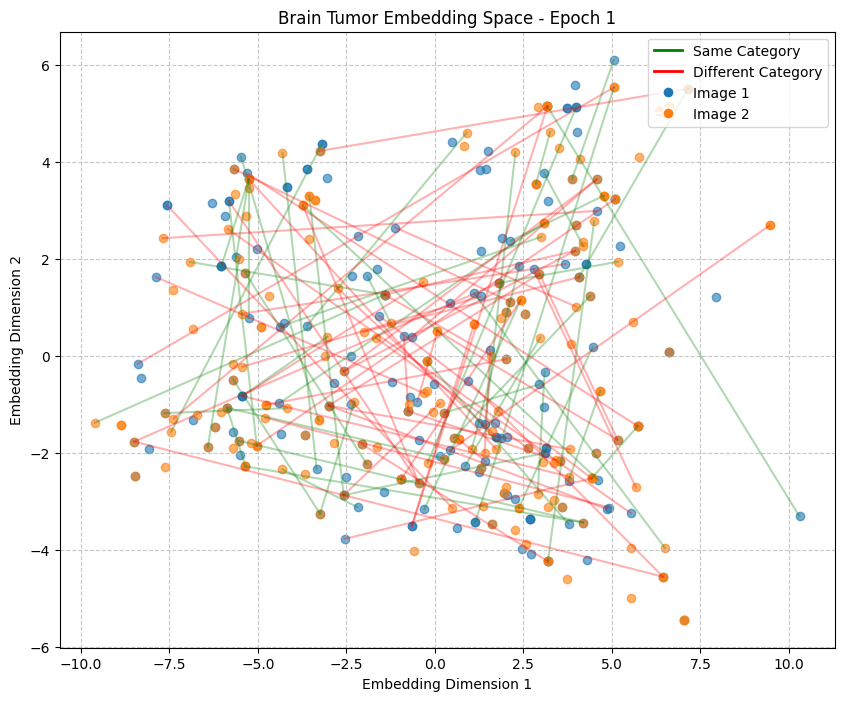

26/26 ━━━━━━━━━━━━━━━━━━━━ 134s 3s/step - compute_contrastive_accuracy: 0.5398 - loss: 0.6323 - val_compute_contrastive_accuracy: 0.4621 - val_loss: 0.5628
Epoch 2/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - compute_contrastive_accuracy: 0.6633 - loss: 0.5616

Validation Set - Avg distance (same): 0.7215
Validation Set - Avg distance (diff): 0.8744
Distance gap: 0.1529


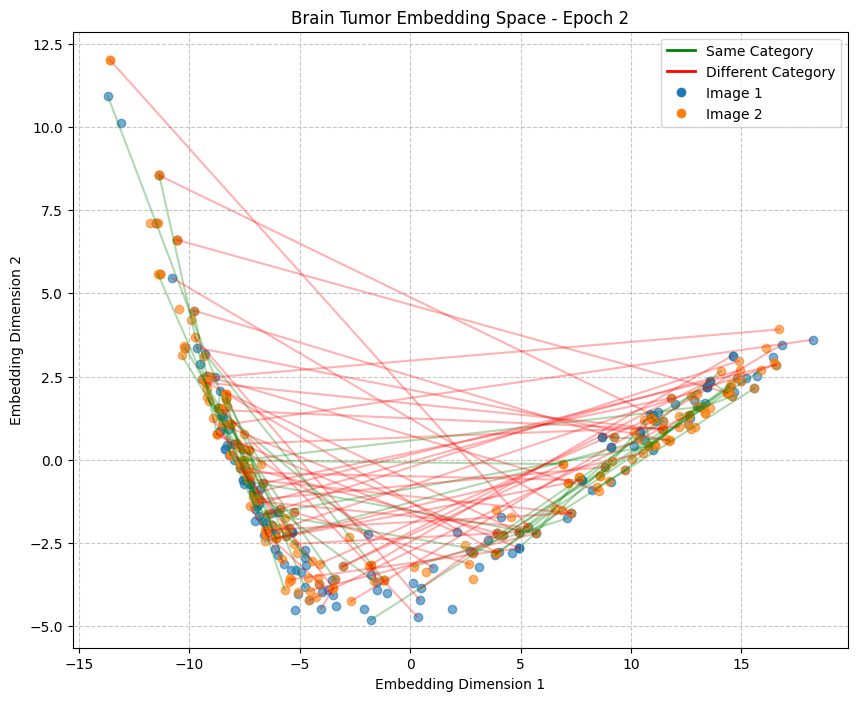

26/26 ━━━━━━━━━━━━━━━━━━━━ 51s 548ms/step - compute_contrastive_accuracy: 0.6638 - loss: 0.5619 - val_compute_contrastive_accuracy: 0.5067 - val_loss: 0.4853
Epoch 3/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - compute_contrastive_accuracy: 0.7345 - loss: 0.5233

Validation Set - Avg distance (same): 0.6254
Validation Set - Avg distance (diff): 0.8551
Distance gap: 0.2297


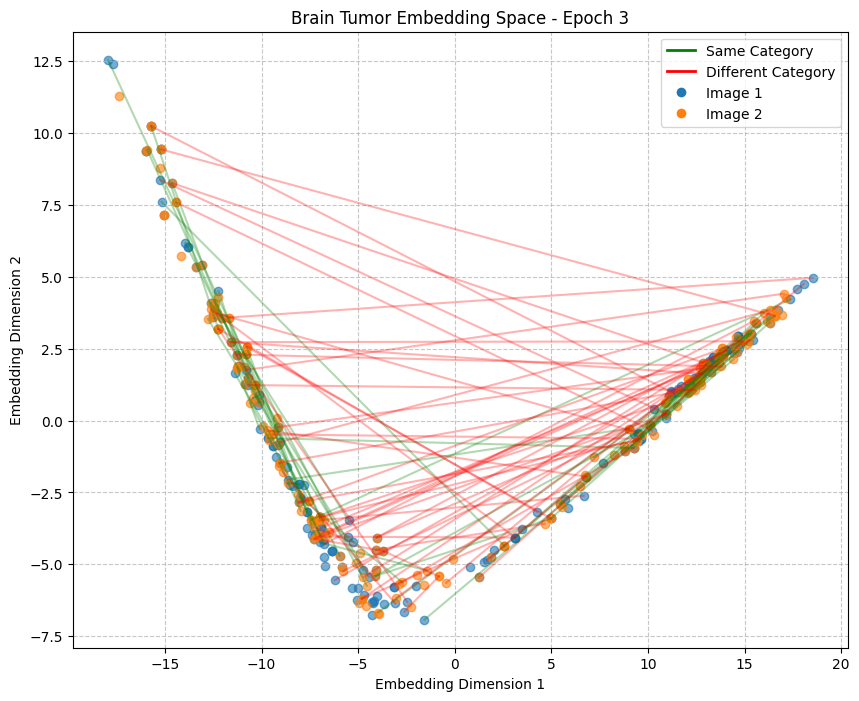

26/26 ━━━━━━━━━━━━━━━━━━━━ 21s 565ms/step - compute_contrastive_accuracy: 0.7358 - loss: 0.5227 - val_compute_contrastive_accuracy: 0.5759 - val_loss: 0.4252
Epoch 4/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - compute_contrastive_accuracy: 0.7784 - loss: 0.4568

Validation Set - Avg distance (same): 0.5781
Validation Set - Avg distance (diff): 0.8504
Distance gap: 0.2722


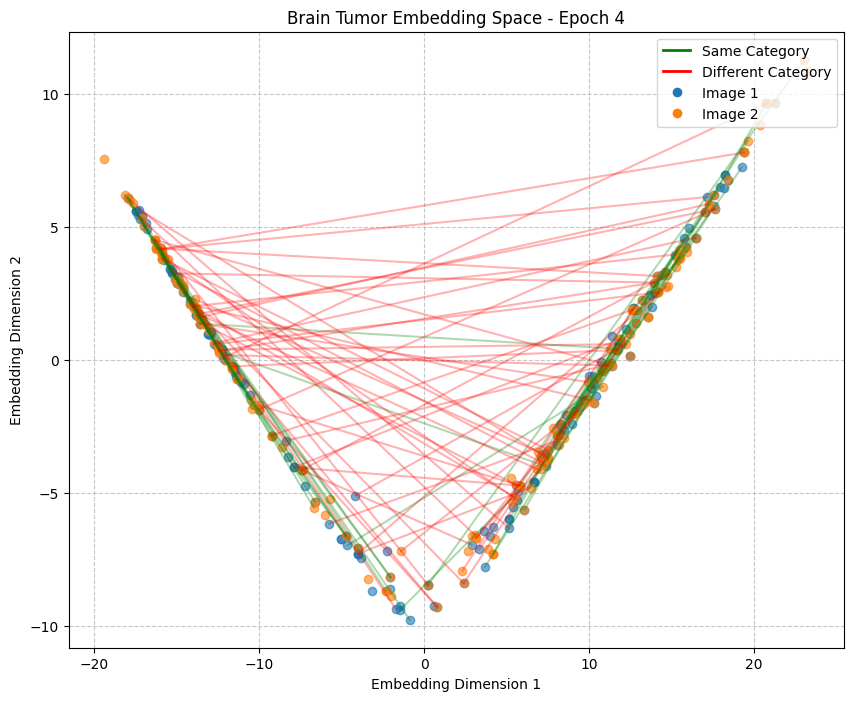

26/26 ━━━━━━━━━━━━━━━━━━━━ 14s 563ms/step - compute_contrastive_accuracy: 0.7795 - loss: 0.4569 - val_compute_contrastive_accuracy: 0.7076 - val_loss: 0.3780
Epoch 5/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - compute_contrastive_accuracy: 0.8644 - loss: 0.4202

Validation Set - Avg distance (same): 0.4716
Validation Set - Avg distance (diff): 0.8656
Distance gap: 0.3939


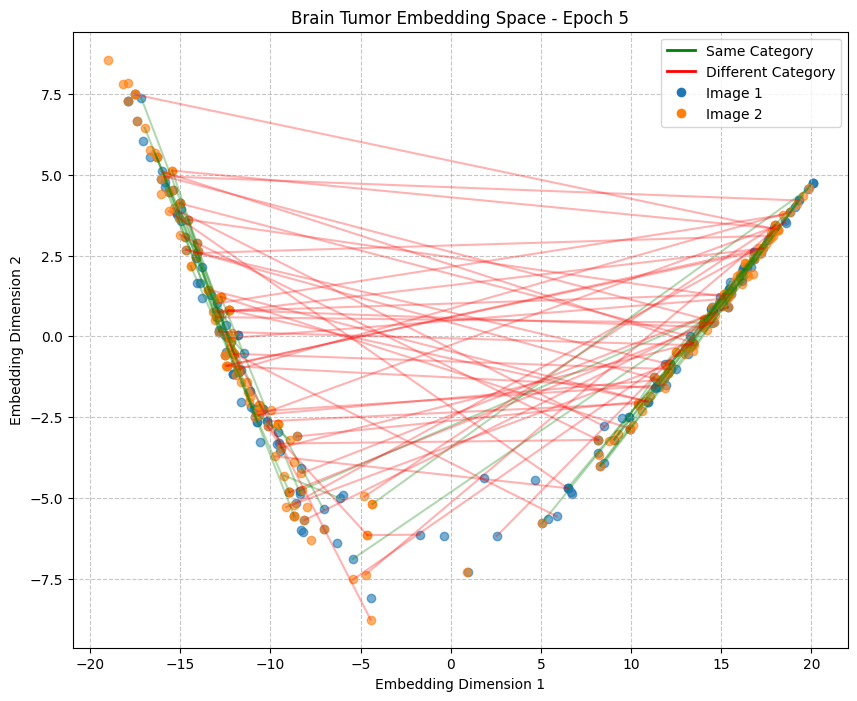

26/26 ━━━━━━━━━━━━━━━━━━━━ 21s 566ms/step - compute_contrastive_accuracy: 0.8656 - loss: 0.4199 - val_compute_contrastive_accuracy: 0.8304 - val_loss: 0.3402
Epoch 6/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - compute_contrastive_accuracy: 0.9366 - loss: 0.4074

Validation Set - Avg distance (same): 0.3999
Validation Set - Avg distance (diff): 0.8329
Distance gap: 0.4329


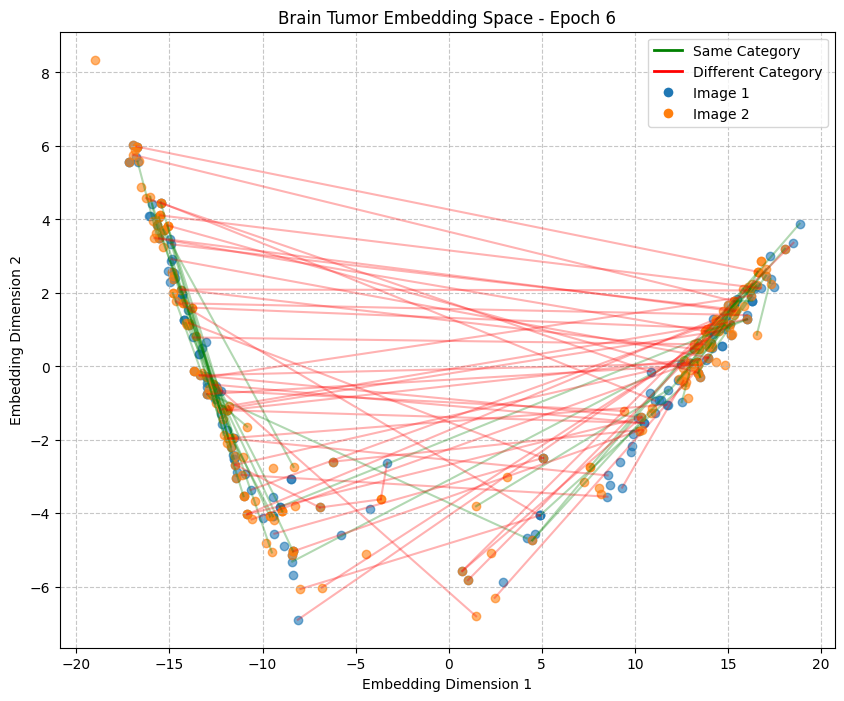

26/26 ━━━━━━━━━━━━━━━━━━━━ 21s 579ms/step - compute_contrastive_accuracy: 0.9373 - loss: 0.4066 - val_compute_contrastive_accuracy: 0.9152 - val_loss: 0.3175
Epoch 7/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - compute_contrastive_accuracy: 0.9768 - loss: 0.3885

Validation Set - Avg distance (same): 0.3749
Validation Set - Avg distance (diff): 0.8400
Distance gap: 0.4651


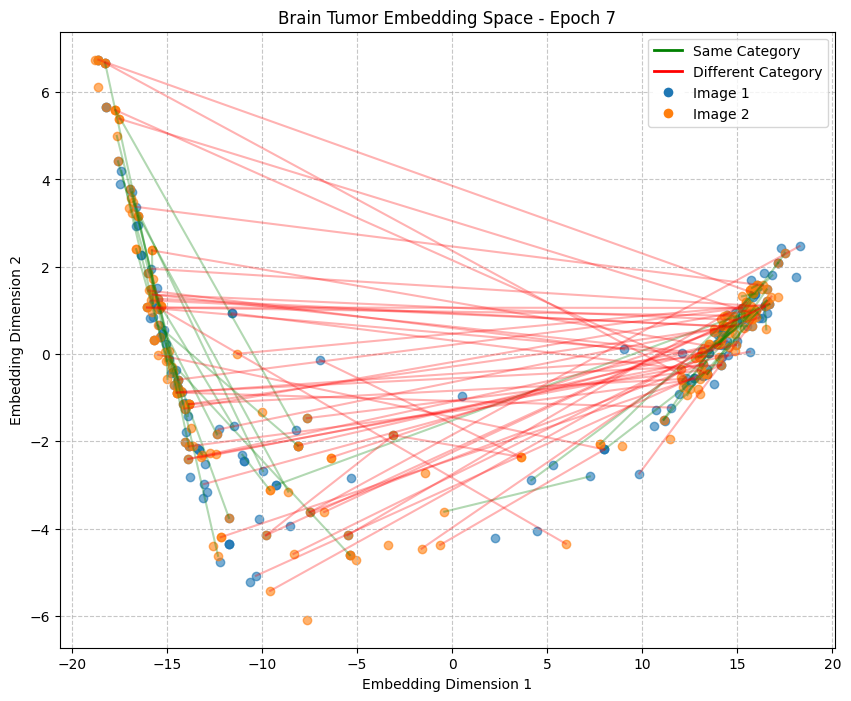

26/26 ━━━━━━━━━━━━━━━━━━━━ 21s 597ms/step - compute_contrastive_accuracy: 0.9768 - loss: 0.3876 - val_compute_contrastive_accuracy: 0.9107 - val_loss: 0.3051
Epoch 8/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - compute_contrastive_accuracy: 0.9847 - loss: 0.3430Validation Set - Avg distance (same): 0.3774
Validation Set - Avg distance (diff): 0.7787
Distance gap: 0.4013


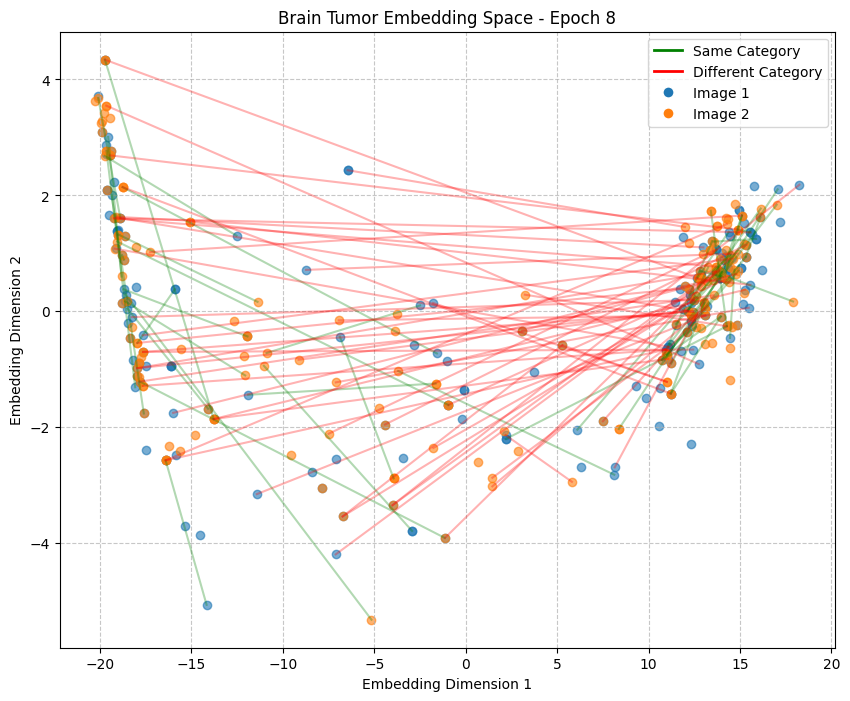

26/26 ━━━━━━━━━━━━━━━━━━━━ 14s 538ms/step - compute_contrastive_accuracy: 0.9846 - loss: 0.3431 - val_compute_contrastive_accuracy: 0.8951 - val_loss: 0.3470
Epoch 9/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - compute_contrastive_accuracy: 0.9844 - loss: 0.3339Validation Set - Avg distance (same): 0.3332
Validation Set - Avg distance (diff): 0.8128
Distance gap: 0.4796


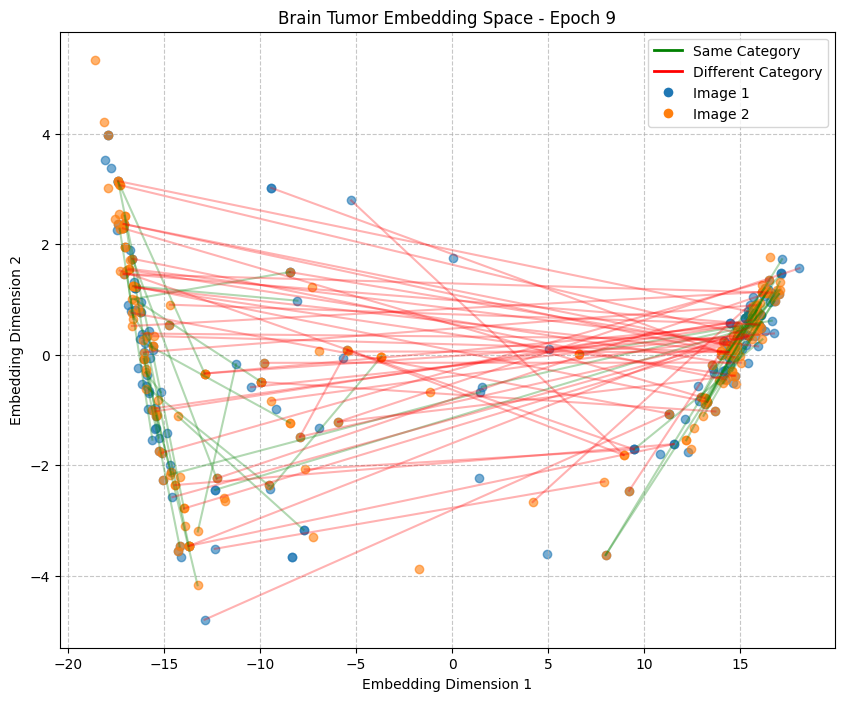

26/26 ━━━━━━━━━━━━━━━━━━━━ 20s 521ms/step - compute_contrastive_accuracy: 0.9846 - loss: 0.3329 - val_compute_contrastive_accuracy: 0.9219 - val_loss: 0.3295
Epoch 10/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - compute_contrastive_accuracy: 0.9983 - loss: 0.2908

Validation Set - Avg distance (same): 0.3132
Validation Set - Avg distance (diff): 0.8459
Distance gap: 0.5327


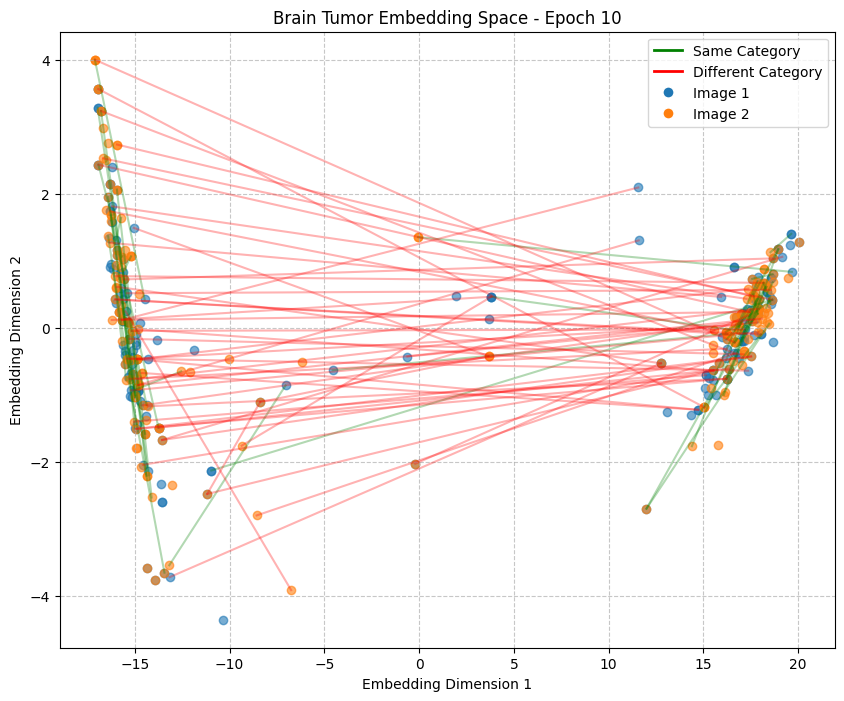

26/26 ━━━━━━━━━━━━━━━━━━━━ 21s 553ms/step - compute_contrastive_accuracy: 0.9983 - loss: 0.2912 - val_compute_contrastive_accuracy: 0.9531 - val_loss: 0.2497
Epoch 11/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - compute_contrastive_accuracy: 0.9999 - loss: 0.2874Validation Set - Avg distance (same): 0.2824
Validation Set - Avg distance (diff): 0.8489
Distance gap: 0.5665


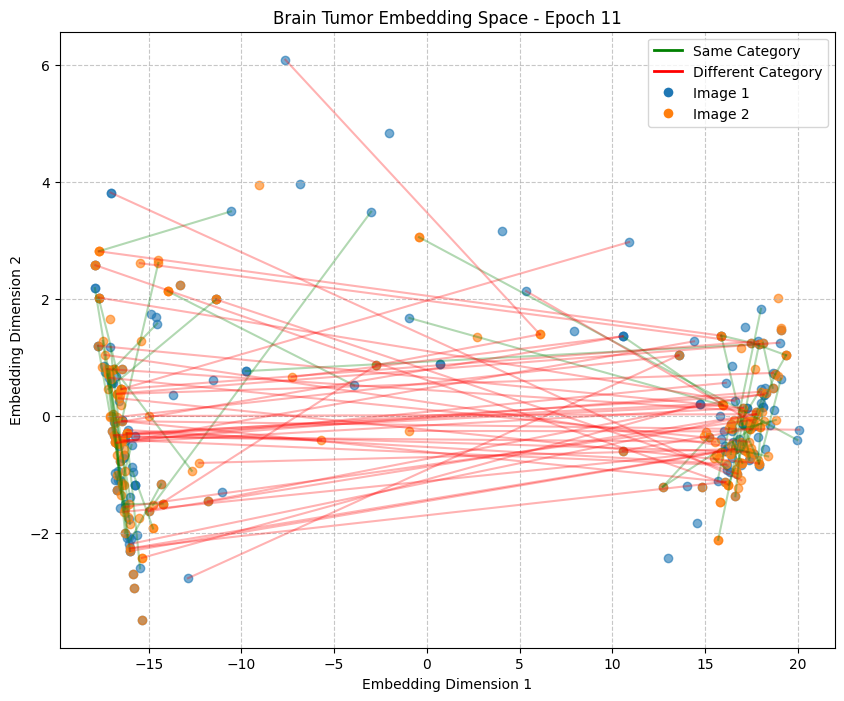

26/26 ━━━━━━━━━━━━━━━━━━━━ 13s 529ms/step - compute_contrastive_accuracy: 0.9998 - loss: 0.2875 - val_compute_contrastive_accuracy: 0.9643 - val_loss: 0.2647
Epoch 12/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - compute_contrastive_accuracy: 0.9963 - loss: 0.2665Validation Set - Avg distance (same): 0.2980
Validation Set - Avg distance (diff): 0.8316
Distance gap: 0.5336


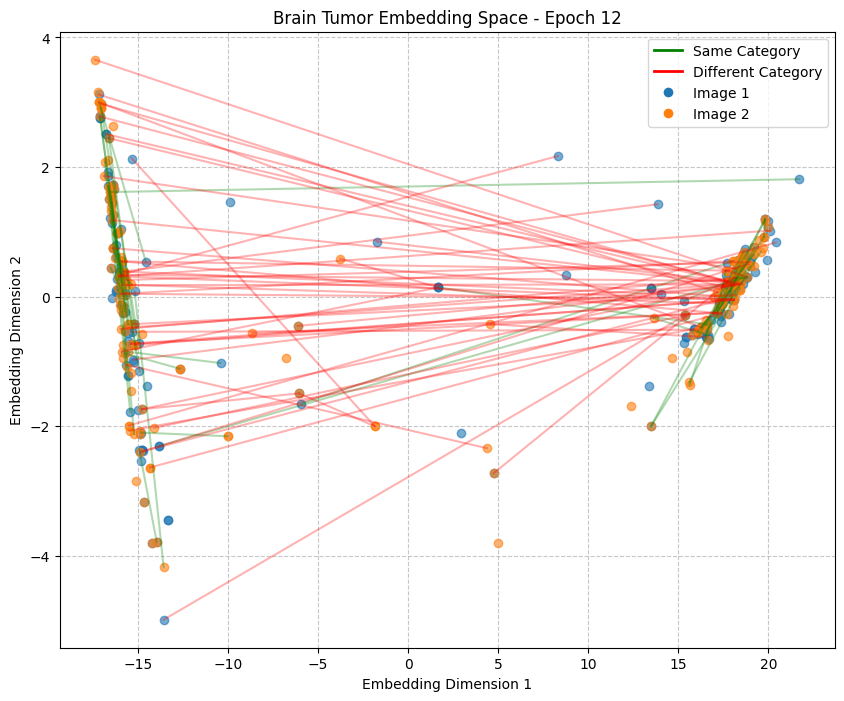

26/26 ━━━━━━━━━━━━━━━━━━━━ 13s 518ms/step - compute_contrastive_accuracy: 0.9963 - loss: 0.2668 - val_compute_contrastive_accuracy: 0.9330 - val_loss: 0.2961
Epoch 13/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - compute_contrastive_accuracy: 0.9962 - loss: 0.2756Validation Set - Avg distance (same): 0.3033
Validation Set - Avg distance (diff): 0.8237
Distance gap: 0.5203


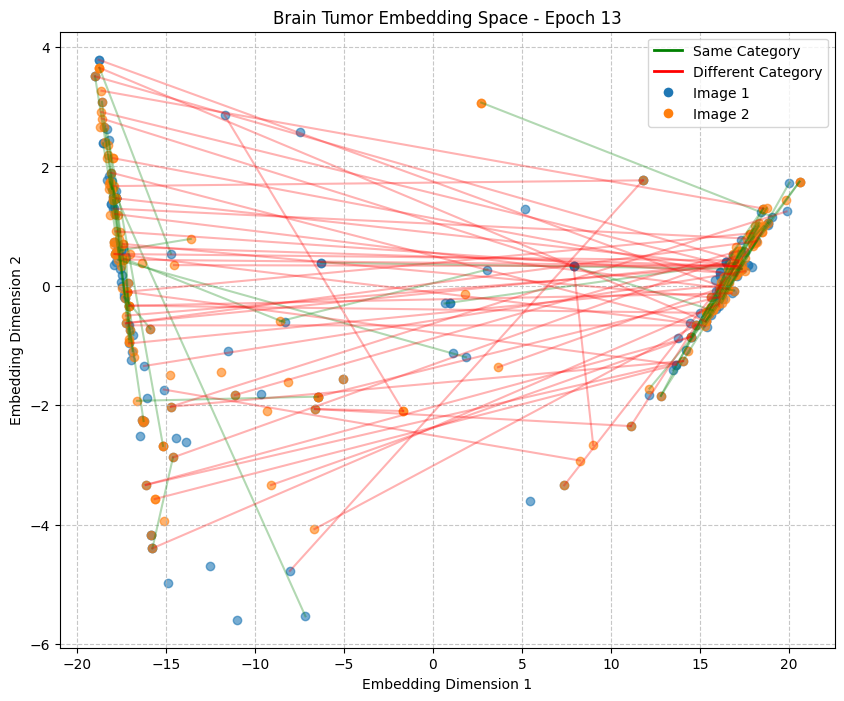

26/26 ━━━━━━━━━━━━━━━━━━━━ 13s 521ms/step - compute_contrastive_accuracy: 0.9960 - loss: 0.2757 - val_compute_contrastive_accuracy: 0.8951 - val_loss: 0.2938
Epoch 14/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - compute_contrastive_accuracy: 0.9922 - loss: 0.3053Validation Set - Avg distance (same): 0.3231
Validation Set - Avg distance (diff): 0.8022
Distance gap: 0.4791


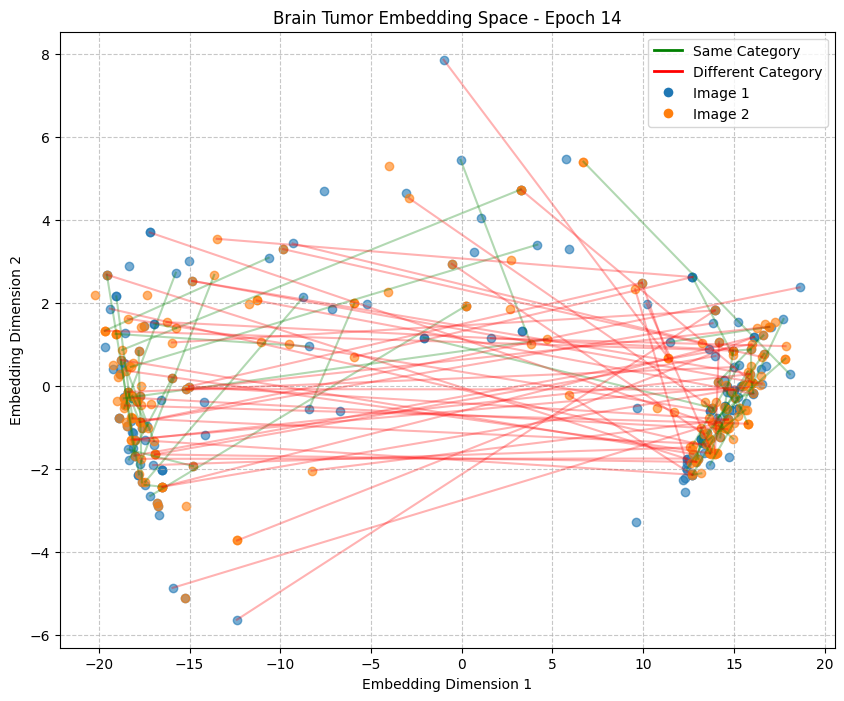

26/26 ━━━━━━━━━━━━━━━━━━━━ 13s 495ms/step - compute_contrastive_accuracy: 0.9921 - loss: 0.3045 - val_compute_contrastive_accuracy: 0.8571 - val_loss: 0.3434
Epoch 15/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - compute_contrastive_accuracy: 0.9960 - loss: 0.2777Validation Set - Avg distance (same): 0.2783
Validation Set - Avg distance (diff): 0.8538
Distance gap: 0.5755


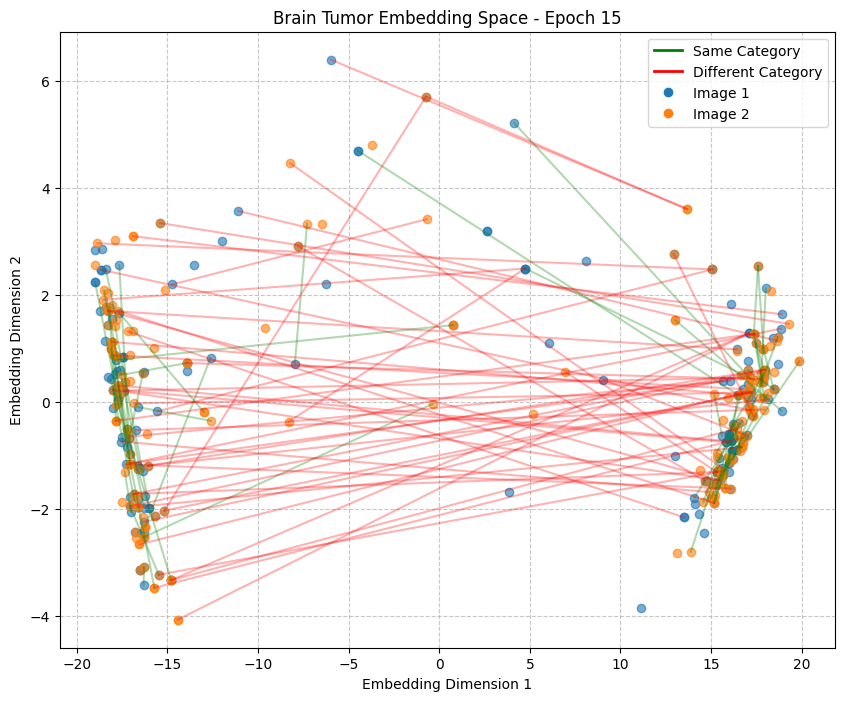

26/26 ━━━━━━━━━━━━━━━━━━━━ 21s 510ms/step - compute_contrastive_accuracy: 0.9959 - loss: 0.2772 - val_compute_contrastive_accuracy: 0.9152 - val_loss: 0.2775


In [ ]:
# Train the model
history = siamese_network.fit(
    train_gen,
    epochs=30,
    validation_data=val_gen,
    callbacks=callbacks,
    verbose=1
)

In [ ]:
import os
import pickle
import json
from datetime import datetime

# Create a timestamp for unique model names
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
model_dir = f"./saved_models_{timestamp}"
os.makedirs(model_dir, exist_ok=True)

print(f"Saving models to: {model_dir}")

# 1. Save the complete Siamese model (recommended)
siamese_model_path = os.path.join(model_dir, "siamese_model_complete.h5")
siamese_network.save(siamese_model_path)
print(f"✅ Complete Siamese model saved to: {siamese_model_path}")

Saving models to: ./saved_models_20250603_135434
✅ Complete Siamese model saved to: ./saved_models_20250603_135434/siamese_model_complete.h5


In [ ]:
import os
import pickle
import json
from datetime import datetime
def load_siamese_model(model_dir):
    """
    Load a saved Siamese model and its components

    Args:
        model_dir: Directory containing saved model files

    Returns:
        tuple: (siamese_model, embedding_network, training_history, distance_history, config)
    """
    # Load complete model
    siamese_model = tf.keras.models.load_model(
        os.path.join(model_dir, "siamese_complete.h5"),
        custom_objects={
            'contrastive_loss': contrastive_loss(margin=1.5),
            'compute_contrastive_accuracy': compute_contrastive_accuracy,
            'euclidean_distance': euclidean_distance
        }
    )
    return siamese_model

# Load everything back
loaded_model = load_siamese_model('./saved_models_20240603_143022')

FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = './saved_models_20240603_143022/siamese_complete.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

results on test

In [ ]:
# Evaluate the model on test data using the test generator
print("Evaluating model on test data...")
steps_test = len(test_gen)
test_loss, test_acc = siamese_network.evaluate(
    test_gen,
    steps=steps_test,
    verbose=1
)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")


Evaluating model on test data...


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 162ms/step - compute_contrastive_accuracy: 0.9362 - loss: 0.2790
Test Loss: 0.2730
Test Accuracy: 0.9487


In [ ]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score, confusion_matrix
import seaborn as sns


def evaluate_siamese_performance(model, data_generator, threshold=0.5):
    """Comprehensive evaluation of Siamese network performance"""
    # Get all distances and labels
    all_distances = []
    all_labels = []

    for i in range(len(data_generator)):
        (images_a, images_b), labels = data_generator[i]
        distances = model.predict([images_a, images_b], verbose=0).flatten()
        all_distances.extend(distances)
        all_labels.extend(labels)

    all_distances = np.array(all_distances)
    all_labels = np.array(all_labels)

    # Get similar and dissimilar distances
    similar_distances = all_distances[all_labels == 0]
    dissimilar_distances = all_distances[all_labels == 1]

    # Calculate basic statistics
    similar_mean = np.mean(similar_distances)
    similar_std = np.std(similar_distances)
    dissimilar_mean = np.mean(dissimilar_distances)
    dissimilar_std = np.std(dissimilar_distances)

    # Calculate ROC and PR curves
    fpr, tpr, thresholds_roc = roc_curve(all_labels, all_distances)
    roc_auc = auc(fpr, tpr)

    precision, recall, thresholds_pr = precision_recall_curve(all_labels, all_distances)
    pr_auc = average_precision_score(all_labels, all_distances)

    # Find optimal threshold using Youden's J statistic (maximizes tpr - fpr)
    j_scores = tpr - fpr
    best_idx = np.argmax(j_scores)
    optimal_threshold = thresholds_roc[best_idx]

    # Calculate predictions and accuracy with optimal threshold
    predictions = (all_distances > optimal_threshold).astype(int)
    accuracy = np.mean(predictions == all_labels)

    # Calculate confusion matrix
    cm = confusion_matrix(all_labels, predictions)

    results = {
        'similar_mean': similar_mean,
        'similar_std': similar_std,
        'dissimilar_mean': dissimilar_mean,
        'dissimilar_std': dissimilar_std,
        'roc_auc': roc_auc,
        'pr_auc': pr_auc,
        'optimal_threshold': optimal_threshold,
        'accuracy': accuracy,
        'confusion_matrix': cm,
        'fpr': fpr,
        'tpr': tpr,
        'precision': precision,
        'recall': recall,
        'all_distances': all_distances,
        'all_labels': all_labels
    }

    return results

    # Evaluate on test set using the optimal threshold
print("\n--- Test Set Evaluation ---")
test_results = evaluate_siamese_performance(siamese_network, test_gen)

print(f"Test Results:")
print(f"Similar pairs - mean: {test_results['similar_mean']:.4f}, std: {test_results['similar_std']:.4f}")
print(f"Dissimilar pairs - mean: {test_results['dissimilar_mean']:.4f}, std: {test_results['dissimilar_std']:.4f}")
print(f"ROC AUC: {test_results['roc_auc']:.4f}")
print(f"PR AUC: {test_results['pr_auc']:.4f}")
print(f"Accuracy with optimal threshold: {test_results['accuracy']:.4f}")

# Enhanced visualization of results
plt.figure(figsize=(20, 15))



--- Test Set Evaluation ---
Test Results:
Similar pairs - mean: 0.6628, std: 0.1767
Dissimilar pairs - mean: 0.8887, std: 0.1438
ROC AUC: 0.8532
PR AUC: 0.8270
Accuracy with optimal threshold: 0.8229


<Figure size 2000x1500 with 0 Axes>

<Figure size 2000x1500 with 0 Axes>

# CNN vs SNN


=== Creating imbalanced datasets (20/1000 train, 4/200 val/test) ===
Found 826 original images for Training - class 'glioma_tumor'
Found 822 original images for Training - class 'meningioma_tumor'
Found 50 original images for Validation - class 'glioma_tumor'
Found 50 original images for Validation - class 'meningioma_tumor'
Found 50 original images for Testing - class 'glioma_tumor'
Found 65 original images for Testing - class 'meningioma_tumor'
Created imbalanced Training set: 20 images from 'glioma_tumor'
Created imbalanced Training set: 822 images from 'meningioma_tumor'
Created imbalanced Validation set: 4 images from 'glioma_tumor'
Created imbalanced Validation set: 50 images from 'meningioma_tumor'
Created imbalanced Testing set: 4 images from 'glioma_tumor'
Created imbalanced Testing set: 65 images from 'meningioma_tumor'
Found 1005 images belonging to 2 classes.
Found 80 images belonging to 2 classes.
Found 93 images belonging to 2 classes.
Found 1005 images belonging to 2 cl

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_11 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ densenet121 (Functional)        │ (None, 1024)           │     7,037,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,173,058 (27.36 MB)

 Trainable params: 133,506 (521.51 KB)

 Non-trainable params: 7,039,552 (26.85 MB)


--- Training CNN with imbalanced data ---
Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 543ms/step - accuracy: 0.7596 - loss: 0.4762

32/32 ━━━━━━━━━━━━━━━━━━━━ 68s 1s/step - accuracy: 0.7621 - loss: 0.4722 - val_accuracy: 0.6375 - val_loss: 1.5140
Epoch 2/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.9434 - loss: 0.1393

32/32 ━━━━━━━━━━━━━━━━━━━━ 33s 133ms/step - accuracy: 0.9433 - loss: 0.1399 - val_accuracy: 0.6500 - val_loss: 1.1887
Epoch 3/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 97ms/step - accuracy: 0.9575 - loss: 0.1172 - val_accuracy: 0.6500 - val_loss: 1.2626
Epoch 4/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 91ms/step - accuracy: 0.9709 - loss: 0.0921 - val_accuracy: 0.6875 - val_loss: 1.2380
Epoch 5/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 96ms/step - accuracy: 0.9851 - loss: 0.0599 - val_accuracy: 0.6500 - val_loss: 1.5250
Epoch 6/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 121ms/step - accuracy: 0.9889 - loss: 0.0412 - val_accuracy: 0.6625 - val_loss: 1.5535
Epoch 7/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 95ms/step - accuracy: 0.9785 - loss: 0.0572 - val_accuracy: 0.6625 - val_loss: 1.8891
3/3 ━━━━━━━━━━━━━━━━━━━━ 13s 6s/step - accuracy: 0.5213 - loss: 1.7914
CNN - Test Loss: 1.1421, Test Accuracy: 0.6989

=== Building and Training Siamese Neural Network ===


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_14      │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_15      │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_6        │ (None, 128)       │  7,630,016 │ input_layer_14[0… │
│ (Functional)        │                   │            │ input_layer_15[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_2 (Lambda)   │ (None, 1)         │          0 │ functional_6[0][… │
│                     │                   │            │ functional_6[1][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1)         │          4 │ lambda_2[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_12 (Dense)    │ (None, 1)         │          2 │ batch_normalizat… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 7,630,022 (29.11 MB)

 Trainable params: 958,660 (3.66 MB)

 Non-trainable params: 6,671,362 (25.45 MB)

Cached 64 samples for embedding visualization

--- Training SNN with pairs from the imbalanced data ---
Epoch 1/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - compute_contrastive_accuracy: 0.4957 - loss: 0.6810

Validation Set - Avg distance (same): 0.1569
Validation Set - Avg distance (diff): 0.1520
Distance gap: -0.0049


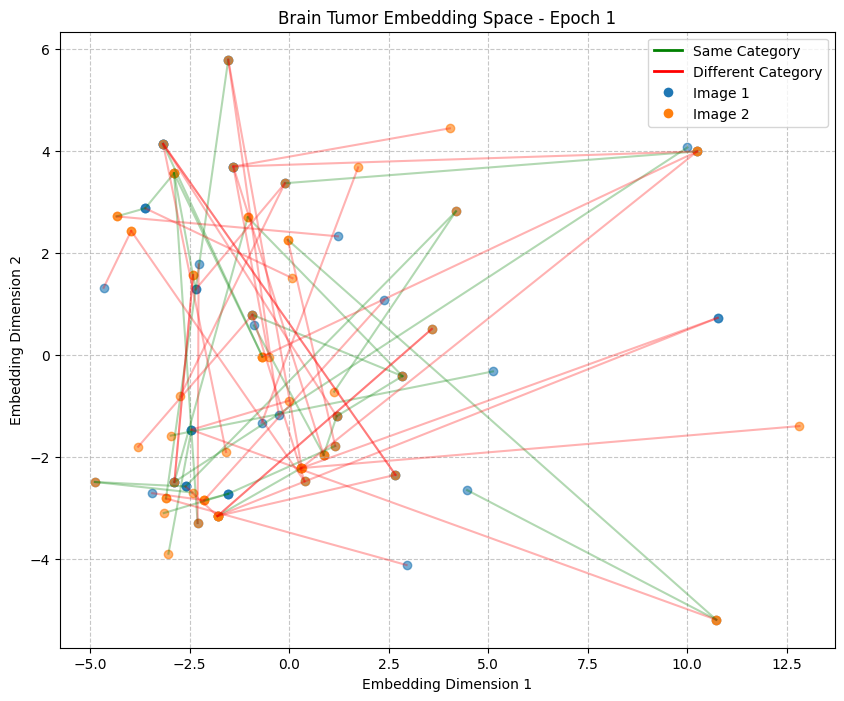

31/31 ━━━━━━━━━━━━━━━━━━━━ 552s 17s/step - compute_contrastive_accuracy: 0.4956 - loss: 0.6807 - val_compute_contrastive_accuracy: 0.5156 - val_loss: 0.9734
Epoch 2/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - compute_contrastive_accuracy: 0.4565 - loss: 0.6386

Validation Set - Avg distance (same): 0.2896
Validation Set - Avg distance (diff): 0.2725
Distance gap: -0.0172


In [ ]:
import os
import shutil
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras import layers, Model, Input
from tensorflow.keras.layers import Dropout, GlobalAveragePooling2D, Dense, BatchNormalization, Lambda
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, classification_report
import time
# Required helper functions for SNN (copied from your original code)
# ===========================================================================

# Define a Siamese network with DenseNet121 as the base model
def build_siamese_network(input_shape):
    # Load pre-trained DenseNet121 with ImageNet weights
    base_model = DenseNet121(
        weights='imagenet',
        include_top=False,
        input_shape=input_shape
    )

    # Freeze the pre-trained layers except for the last 20 layers
    for layer in base_model.layers[:-20]:
        layer.trainable = False

    # Add custom layers on top of DenseNet121
    input = keras.layers.Input(input_shape)
    x = base_model(input)

    # Global pooling to reduce dimensions
    x = keras.layers.GlobalAveragePooling2D()(x)

    # Additional dense layers for feature extraction
    x = keras.layers.Dense(512, activation="relu")(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Dropout(0.2)(x)
    x = keras.layers.Dense(128, activation="relu")(x)

    return keras.Model(input, x)

# Define contrastive loss function
def contrastive_loss(margin=1.0):
    def loss(y_true, y_pred):
        square_pred = tf.square(y_pred)
        margin_square = tf.square(tf.maximum(margin - y_pred, 0))
        return tf.reduce_mean((1 - y_true) * square_pred + (y_true) * margin_square)
    return loss

# Euclidean Distance Function
def euclidean_distance(vects):
    x, y = vects
    sum_square = tf.reduce_sum(tf.square(x - y), axis=1, keepdims=True)
    return tf.sqrt(tf.maximum(sum_square, keras.backend.epsilon()))

# Accuracy metric for contrastive loss
def compute_contrastive_accuracy(y_true, y_pred, threshold=0.5):
    return tf.keras.metrics.binary_accuracy(y_true, tf.cast(y_pred > threshold, tf.float32))


import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import shutil
import random

# Function to create imbalanced datasets for training, validation, and testing
def create_imbalanced_datasets(base_dir, target_size=(224, 224), batch_size=32):
    """
    Creates imbalanced datasets for train, validation, and test sets with the same ratio.
    - Training: 20 samples from class 0, 1000 samples from class 1
    - Validation: 4 samples from class 0, 200 samples from class 1 (5x smaller)
    - Testing: 4 samples from class 0, 200 samples from class 1 (5x smaller)
    """
    classes = ["glioma_tumor", "meningioma_tumor"]

    # Define the imbalance ratios
    train_imbalance = {
        classes[0]: 20,   # 20 images for first class
        classes[1]: 1000  # 1000 images for second class
    }

    # Validation and test sets are 5 times smaller but maintain the same ratio
    val_test_imbalance = {
        classes[0]: train_imbalance[classes[0]] // 5,  # 4 images
        classes[1]: train_imbalance[classes[1]] // 5   # 200 images
    }

    # First, collect all source image paths
    class_images = {}
    for split in ["Training", "Validation", "Testing"]:
        class_images[split] = {}
        for cls in classes:
            class_path = os.path.join(base_dir, split, cls)
            class_images[split][cls] = []
            for img_name in os.listdir(class_path):
                if img_name.lower().endswith(('.jpg', '.jpeg', '.png')):
                    class_images[split][cls].append(os.path.join(class_path, img_name))
            print(f"Found {len(class_images[split][cls])} original images for {split} - class '{cls}'")

    # Create imbalanced dataset directory structure
    imbalanced_dir = "./imbalanced_dataset"
    os.makedirs(imbalanced_dir, exist_ok=True)

    # Create split directories
    for split in ["Training", "Validation", "Testing"]:
        for cls in classes:
            os.makedirs(os.path.join(imbalanced_dir, split, cls), exist_ok=True)

    # Create imbalanced splits for each set
    for split in ["Training", "Validation", "Testing"]:
        # Determine which imbalance ratio to use
        if split == "Training":
            imbalance = train_imbalance
        else:
            imbalance = val_test_imbalance

        # Select and copy images for each class in this split
        for cls in classes:
            # Determine how many images to use (limited by available images)
            count = min(imbalance[cls], len(class_images[split][cls]))

            # Randomly select images
            selected_images = random.sample(class_images[split][cls], count)

            # Copy selected images to imbalanced dataset
            for img_path in selected_images:
                img_name = os.path.basename(img_path)
                dest_path = os.path.join(imbalanced_dir, split, cls, img_name)
                shutil.copy(img_path, dest_path)

            print(f"Created imbalanced {split} set: {count} images from '{cls}'")

    # Create data generators for CNN
    datagen = ImageDataGenerator(rescale=1./255)

    # Create generators for CNN
    train_generator = datagen.flow_from_directory(
        os.path.join(imbalanced_dir, "Training"),
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True
    )

    val_generator = datagen.flow_from_directory(
        os.path.join(imbalanced_dir, "Validation"),
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False
    )

    test_generator = datagen.flow_from_directory(
        os.path.join(imbalanced_dir, "Testing"),
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False
    )

    # Create additional generators for SNN to ensure we're loading fresh data
    train_datagen_snn = ImageDataGenerator(rescale=1./255)
    val_datagen_snn = ImageDataGenerator(rescale=1./255)
    test_datagen_snn = ImageDataGenerator(rescale=1./255)

    train_base_snn = train_datagen_snn.flow_from_directory(
        os.path.join(imbalanced_dir, "Training"),
        target_size=target_size,
        batch_size=batch_size,
        class_mode='binary',
        shuffle=True
    )

    val_base_snn = val_datagen_snn.flow_from_directory(
        os.path.join(imbalanced_dir, "Validation"),
        target_size=target_size,
        batch_size=batch_size,
        class_mode='binary',
        shuffle=False
    )

    test_base_snn = test_datagen_snn.flow_from_directory(
        os.path.join(imbalanced_dir, "Testing"),
        target_size=target_size,
        batch_size=batch_size,
        class_mode='binary',
        shuffle=False
    )

    # Create Siamese pair generators from the imbalanced data
    train_pair_gen = SiamesePairGenerator(train_base_snn, batch_size=batch_size)
    val_pair_gen = SiamesePairGenerator(val_base_snn, batch_size=batch_size)
    test_pair_gen = SiamesePairGenerator(test_base_snn, batch_size=batch_size)

    return {
        'cnn': {
            'train': train_generator,
            'val': val_generator,
            'test': test_generator
        },
        'snn': {
            'train': train_pair_gen,
            'val': val_pair_gen,
            'test': test_pair_gen
        },
        'imbalanced_dir': imbalanced_dir
    }


# Build the CNN model using the same base architecture as the Siamese network
def build_cnn_classifier(input_shape, classes=2):
    """
    Build a CNN classifier using DenseNet121 as base model.
    This uses the same architecture as the embedding part of the Siamese network.
    """
    # Load pre-trained DenseNet121 with ImageNet weights
    base_model = DenseNet121(
        include_top=False,
        weights='imagenet',
        input_shape=input_shape,
        pooling='avg'
    )

    # Freeze the base model layers (same approach as in Siamese)
    base_model.trainable = False

    # Build the model
    inputs = keras.Input(shape=input_shape)
    x = base_model(inputs, training=False)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)

    # Use the same intermediate layer size as in Siamese for fair comparison
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.2)(x)

    # Output layer - binary classification
    outputs = Dense(classes, activation='softmax')(x)

    # Create the model
    model = Model(inputs=inputs, outputs=outputs)
    return model


# Class for visualizing metrics and comparing SNN vs CNN
class MetricsVisualizer:
    @staticmethod
    def plot_training_history(history, title="Training History"):
        """Plot the training history."""
        plt.figure(figsize=(12, 5))

        # Get history dict if it's a keras History object
        if not isinstance(history, dict):
            history = history.history

        # Plot accuracy
        plt.subplot(1, 2, 1)
        if 'accuracy' in history:
            plt.plot(history['accuracy'], label='Train Accuracy')
            plt.plot(history['val_accuracy'], label='Validation Accuracy')
        elif 'compute_contrastive_accuracy' in history:
            plt.plot(history['compute_contrastive_accuracy'], label='Train Accuracy')
            plt.plot(history['val_compute_contrastive_accuracy'], label='Validation Accuracy')

        plt.title('Model Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()

        # Plot loss
        plt.subplot(1, 2, 2)
        plt.plot(history['loss'], label='Train Loss')
        plt.plot(history['val_loss'], label='Validation Loss')
        plt.title('Model Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()

        plt.suptitle(title)
        plt.tight_layout()
        plt.show()

    @staticmethod
    def compare_snn_cnn(snn_history, cnn_history):
        """Compare SNN vs CNN performance."""
        plt.figure(figsize=(15, 10))

        # Create subplots
        plt.subplot(2, 2, 1)
        plt.plot(snn_history['distance_gap'], label='Distance Gap')
        plt.title('SNN - Distance Gap')
        plt.xlabel('Epoch')
        plt.ylabel('Distance')
        plt.grid(True)

        plt.subplot(2, 2, 2)
        plt.plot(snn_history['val_pos_dist'], label='Same Class')
        plt.plot(snn_history['val_neg_dist'], label='Different Class')
        plt.title('SNN - Embedding Distances')
        plt.xlabel('Epoch')
        plt.ylabel('Distance')
        plt.legend()
        plt.grid(True)

        plt.subplot(2, 2, 3)
        plt.plot(cnn_history['accuracy'], label='Train')
        plt.plot(cnn_history['val_accuracy'], label='Validation')
        plt.title('CNN - Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.grid(True)

        plt.subplot(2, 2, 4)
        plt.plot(cnn_history['loss'], label='Train')
        plt.plot(cnn_history['val_loss'], label='Validation')
        plt.title('CNN - Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)

        plt.suptitle('SNN vs CNN Model Comparison (Imbalanced Dataset)', fontsize=16)
        plt.tight_layout()
        plt.subplots_adjust(top=0.9)
        plt.show()


# Main implementation for running both models on the imbalanced datasets
def run_models_with_imbalanced_data(base_dir="/content/gdrive/MyDrive/mini_project_shira_and_tzfiya/Brain_Tumor"):
    """Run both SNN and CNN models using imbalanced datasets."""
    print("\n=== Creating imbalanced datasets (20/1000 train, 4/200 val/test) ===")

    # Create imbalanced datasets for train, validation, and test
    input_shape = (224, 224, 3)
    batch_size = 32
    generators = create_imbalanced_datasets(
        base_dir, target_size=input_shape[:2], batch_size=batch_size
    )

    # Extract generators for CNN and SNN
    train_gen_cnn = generators['cnn']['train']
    val_gen_cnn = generators['cnn']['val']
    test_gen_cnn = generators['cnn']['test']

    train_pair_gen_snn = generators['snn']['train']
    val_pair_gen_snn = generators['snn']['val']
    test_pair_gen_snn = generators['snn']['test']

    imbalanced_dir = generators['imbalanced_dir']

    # STEP 1: Build and train the CNN model first
    print("\n=== Building and Training CNN Model ===")

    # Build CNN model using the same architecture as the embedding part of SNN
    cnn_model = build_cnn_classifier(input_shape)

    # Compile the CNN model
    cnn_model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-3),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    # Print CNN model summary
    cnn_model.summary()

    # Calculate class weights based on the imbalance (20:1000 ratio for training)
    #class_weight = {0: 50.0, 1: 1.0}  # This is approximate; adjust as needed

    # Callbacks for CNN
    cnn_callbacks = [
        keras.callbacks.ModelCheckpoint('cnn_model_imbalanced.h5', save_best_only=True),
        keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True),
    ]

    # Train the CNN model
    print("\n--- Training CNN with imbalanced data ---")
    cnn_history = cnn_model.fit(
        train_gen_cnn,
        epochs=30,
        validation_data=val_gen_cnn,
        callbacks=cnn_callbacks,
        #class_weight=class_weight,  # Apply class weights to handle imbalance
        verbose=1
    )

    # Evaluate CNN on test set
    cnn_test_loss, cnn_test_acc = cnn_model.evaluate(test_gen_cnn, verbose=1)
    print(f"CNN - Test Loss: {cnn_test_loss:.4f}, Test Accuracy: {cnn_test_acc:.4f}")

    # STEP 2: Build the Siamese Network
    print("\n=== Building and Training Siamese Neural Network ===")

    # This is the embedding network
    embedding_network = build_siamese_network(input_shape)

    # Create Siamese model
    input_1 = keras.layers.Input(input_shape)
    input_2 = keras.layers.Input(input_shape)

    tower_1 = embedding_network(input_1)
    tower_2 = embedding_network(input_2)

    merge_layer = keras.layers.Lambda(euclidean_distance, output_shape=(1,))([tower_1, tower_2])
    normal_layer = keras.layers.BatchNormalization()(merge_layer)
    output_layer = keras.layers.Dense(1, activation="sigmoid")(normal_layer)

    siamese_network = keras.Model(inputs=[input_1, input_2], outputs=output_layer)

    # Compile the SNN model
    siamese_network.compile(
        loss=contrastive_loss(margin=1.5),
        optimizer=keras.optimizers.Adam(learning_rate=1e-3),
        metrics=[compute_contrastive_accuracy]
    )

    # Print SNN model summary
    siamese_network.summary()

    # Create callbacks for SNN
    distance_logger = DistanceLogger(validation_generator=train_pair_gen_snn)
    embedding_visualizer = EmbeddingVisualizer(
        validation_generator=val_pair_gen_snn,
        embedding_network=embedding_network,
        num_samples=200,
        class_names=["glioma_tumor", "meningioma_tumor"]
    )

    snn_callbacks = [
        tf.keras.callbacks.ModelCheckpoint('siamese_model_imbalanced.h5', save_best_only=True),
        tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True),
        distance_logger,
        embedding_visualizer
    ]

    # Train the SNN model
    print("\n--- Training SNN with pairs from the imbalanced data ---")
    snn_history = siamese_network.fit(
        train_pair_gen_snn,
        epochs=30,
        validation_data=val_pair_gen_snn,
        callbacks=snn_callbacks,
        verbose=1
    )

    # Evaluate SNN on test set
    snn_test_loss, snn_test_acc = siamese_network.evaluate(
    test_pair_gen_cnn,
    verbose=1)
    print(f"SNN - Test Loss: {snn_test_loss:.4f}, Test Accuracy: {snn_test_acc:.4f}")

    # STEP 3: Visualize and compare results
    visualizer = MetricsVisualizer()

    print("\n=== Visualizing CNN Training History ===")
    visualizer.plot_training_history(cnn_history, title="CNN with Imbalanced Datasets")

    print("\n=== Visualizing SNN Training History ===")
    snn_plot_data = {
        'loss': snn_history.history['loss'],
        'val_loss': snn_history.history['val_loss'],
        'accuracy': snn_history.history['compute_contrastive_accuracy'],
        'val_accuracy': snn_history.history['val_compute_contrastive_accuracy']
    }
    visualizer.plot_training_history(snn_plot_data, title="SNN with Imbalanced Datasets")

    print("\n=== Comparing Models Performance ===")
    visualizer.compare_snn_cnn(distance_logger.history, cnn_history.history)

    return {
        'siamese_network': siamese_network,
        'cnn_model': cnn_model,
        'snn_history': distance_logger.history,
        'cnn_history': cnn_history.history,
        'imbalanced_dir': imbalanced_dir
    }


# Main execution code
if __name__ == "__main__":
    # Execute the implementation
    results = run_models_with_imbalanced_data()

    print("\n=== Training and Evaluation Complete ===")
    print(f"All datasets created with imbalanced class distribution:")
    print(f"  - Training set:")
    print(f"    * Class 0 (glioma_tumor): 20 images")
    print(f"    * Class 1 (meningioma_tumor): 1000 images (or max available)")
    print(f"  - Validation and Test sets:")
    print(f"    * Class 0 (glioma_tumor): 4 images each (1/5 of training)")
    print(f"    * Class 1 (meningioma_tumor): 200 images each (1/5 of training)")
    print(f"\nBoth SNN and CNN models were trained on these imbalanced datasets")
    print(f"Model checkpoints saved as:")
    print(f"  - 'siamese_model_imbalanced.h5'")
    print(f"  - 'cnn_model_imbalanced.h5'")

    # You can access various components from the results dictionary:
    # - results['siamese_network'] - The trained SNN model
    # - results['cnn_model'] - The trained CNN model
    # - results['snn_history'] - The SNN training metrics history
    # - results['cnn_history'] - The CNN training metrics history
    # - results['imbalanced_dir'] - Path to the imbalanced dataset

Creating dataset split...

✅ Dataset split complete.
Split folders created inside: /content/brain_tumor

Creating data generators...
Found 200 images belonging to 2 classes.
Found 100 images belonging to 2 classes.
Found 100 images belonging to 2 classes.
Found 200 images belonging to 2 classes.
Found 100 images belonging to 2 classes.
Found 100 images belonging to 2 classes.

Creating Siamese pair generators...
Base generator has 1 batches
Loaded 200 images with shape (200, 150, 150, 3).
Class distribution: [100 100]
Base generator has 1 batches
Loaded 100 images with shape (100, 150, 150, 3).
Class distribution: [50 50]
Base generator has 1 batches
Loaded 100 images with shape (100, 150, 150, 3).
Class distribution: [50 50]

Visualizing training and validation pairs...


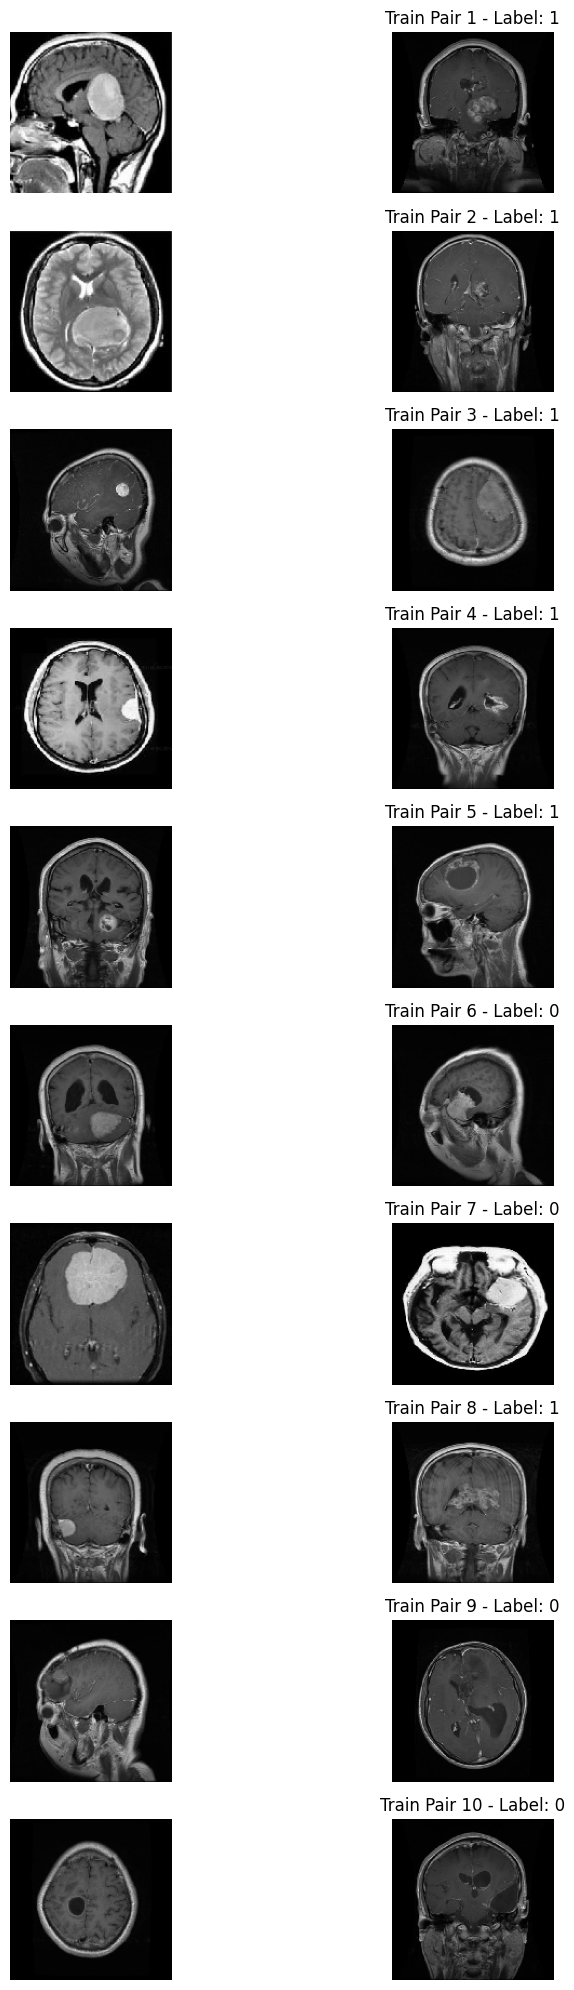

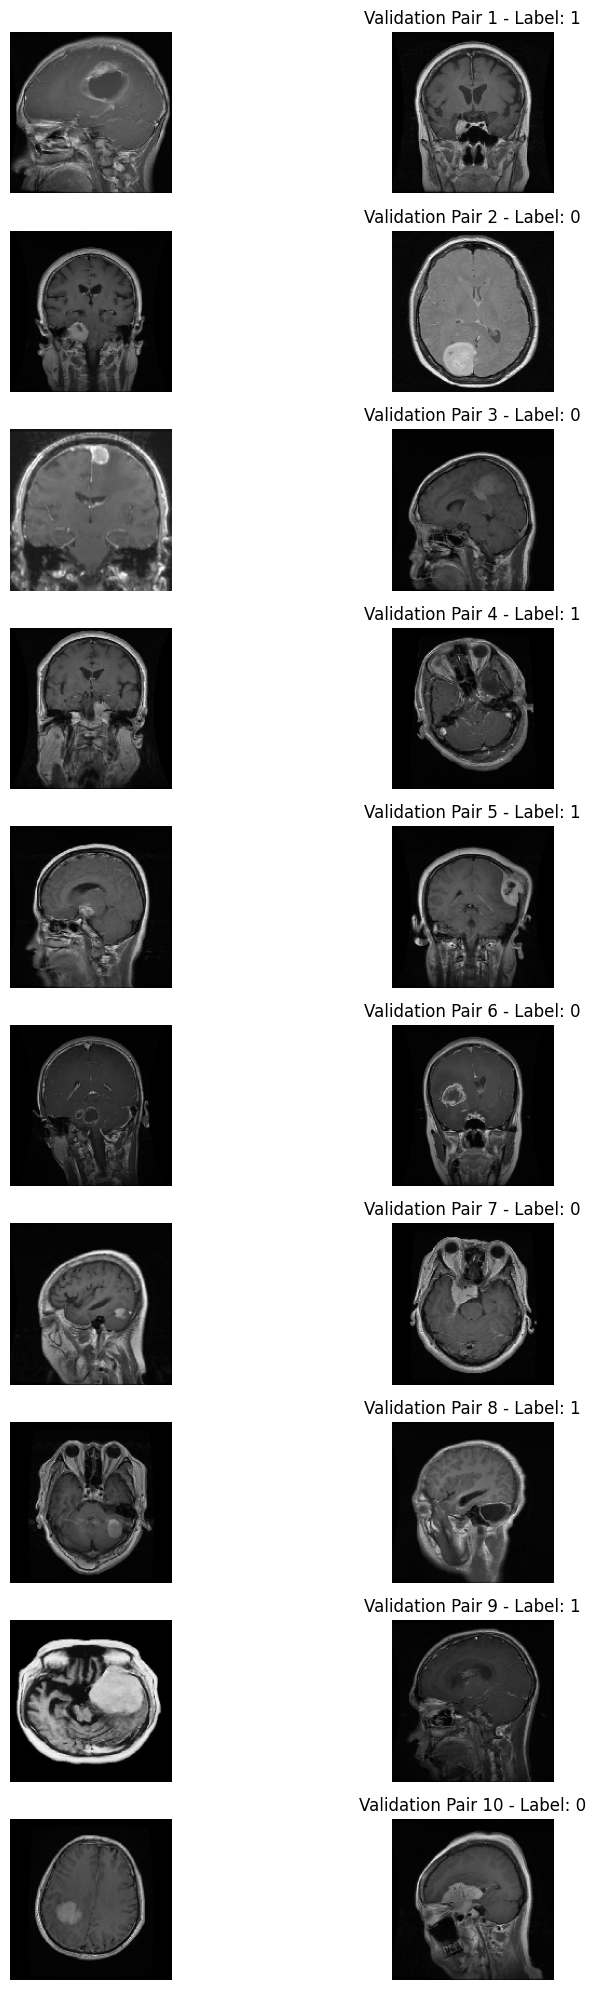


Building models...
29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ densenet121 (Functional)        │ (None, 1024)           │     7,037,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,173,058 (27.36 MB)

 Trainable params: 133,506 (521.51 KB)

 Non-trainable params: 7,039,552 (26.85 MB)

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 150, 150,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_5       │ (None, 150, 150,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_1        │ (None, 128)       │  7,172,800 │ input_layer_4[0]… │
│ (Functional)        │                   │            │ input_layer_5[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ euclidean_distance  │ (None, 1)         │          0 │ functional_1[0][… │
│ (Lambda)            │                   │            │ functional_1[1][… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 7,172,800 (27.36 MB)

 Trainable params: 133,248 (520.50 KB)

 Non-trainable params: 7,039,552 (26.85 MB)


--- Training CNN Classifier ---


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 66s 6s/step - accuracy: 0.5298 - loss: 1.1564 - val_accuracy: 0.5500 - val_loss: 1.5135
Epoch 2/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 269ms/step - accuracy: 0.7508 - loss: 0.4957 - val_accuracy: 0.6400 - val_loss: 0.8178
Epoch 3/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 267ms/step - accuracy: 0.8039 - loss: 0.4277 - val_accuracy: 0.7500 - val_loss: 0.5507
Epoch 4/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 257ms/step - accuracy: 0.8738 - loss: 0.3591 - val_accuracy: 0.8100 - val_loss: 0.5002
Epoch 5/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 328ms/step - accuracy: 0.8699 - loss: 0.2410 - val_accuracy: 0.7100 - val_loss: 0.6002
Epoch 6/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 306ms/step - accuracy: 0.9015 - loss: 0.2655 - val_accuracy: 0.6500 - val_loss: 0.7959
Epoch 7/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 233ms/step - accuracy: 0.8648 - loss: 0.2958 - val_accuracy: 0.6900 - val_loss: 0.7192
Epoch 8/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 224ms/step - accuracy: 0.9357 - loss: 0.1780 - val_accuracy: 0.7100 - val_loss: 0

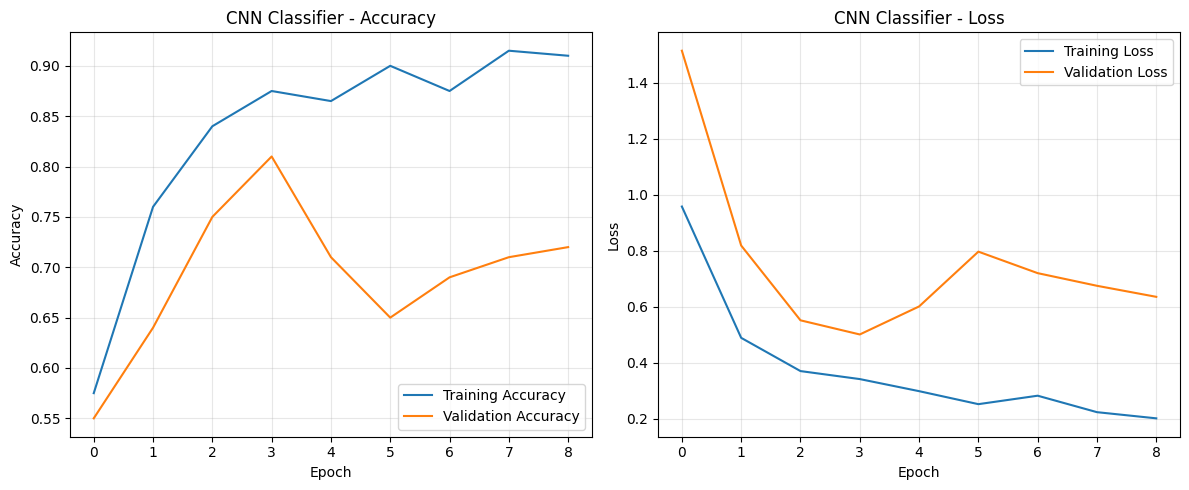


--- Training Siamese Network ---
Epoch 1/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 67s 6s/step - compute_contrastive_accuracy: 0.4478 - loss: 0.7880 - val_compute_contrastive_accuracy: 0.5938 - val_loss: 0.5729
Epoch 2/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 40s 200ms/step - compute_contrastive_accuracy: 0.4865 - loss: 0.7445 - val_compute_contrastive_accuracy: 0.4583 - val_loss: 0.5584
Epoch 3/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 151ms/step - compute_contrastive_accuracy: 0.5333 - loss: 0.6339 - val_compute_contrastive_accuracy: 0.5000 - val_loss: 0.5967
Epoch 4/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 157ms/step - compute_contrastive_accuracy: 0.4984 - loss: 0.6523 - val_compute_contrastive_accuracy: 0.4688 - val_loss: 0.5766
Epoch 5/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 192ms/step - compute_contrastive_accuracy: 0.5513 - loss: 0.5881 - val_compute_contrastive_accuracy: 0.5312 - val_loss: 0.5362
Epoch 6/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 155ms/step - compute_contrastive_accuracy: 0.5761 - loss: 0.5268 - val_compute_contrastive_accurac

<ipython-input-7-f64c60990417>:337: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='lower right')


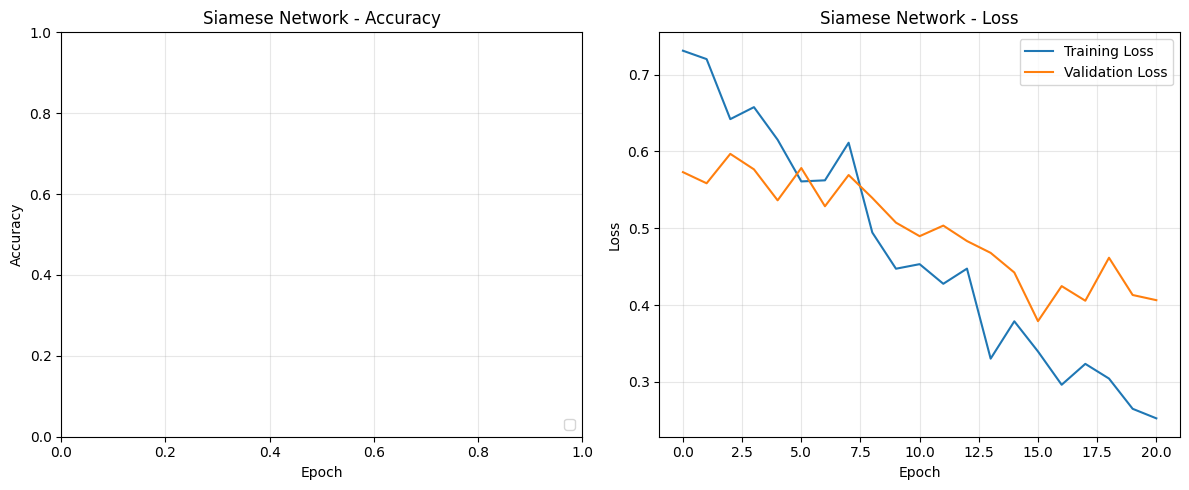


Test Set - Avg distance (same class): 0.7151
Test Set - Avg distance (different class): 0.9727
Distance gap: 0.2577

--- Evaluating CNN Classifier ---
4/4 ━━━━━━━━━━━━━━━━━━━━ 22s 4s/step

--- Evaluating Siamese Network ---

RESULTS COMPARISON

Test Accuracy:
  CNN Classifier: 0.7900
  Siamese Network: 0.7800

Training Time:
  CNN Classifier: 84.14 seconds
  Siamese Network: 129.52 seconds

Inference Time:
  CNN Classifier: 41.23 seconds
  Siamese Network: 44.36 seconds

CNN Classifier Report:
  glioma_tumor:
    Precision: 0.7377
    Recall: 0.9000
    F1-score: 0.8108
  meningioma_tumor:
    Precision: 0.8718
    Recall: 0.6800
    F1-score: 0.7640

Siamese Classifier Report:
  glioma_tumor:
    Precision: 0.7333
    Recall: 0.8800
    F1-score: 0.8000
  meningioma_tumor:
    Precision: 0.8500
    Recall: 0.6800
    F1-score: 0.7556


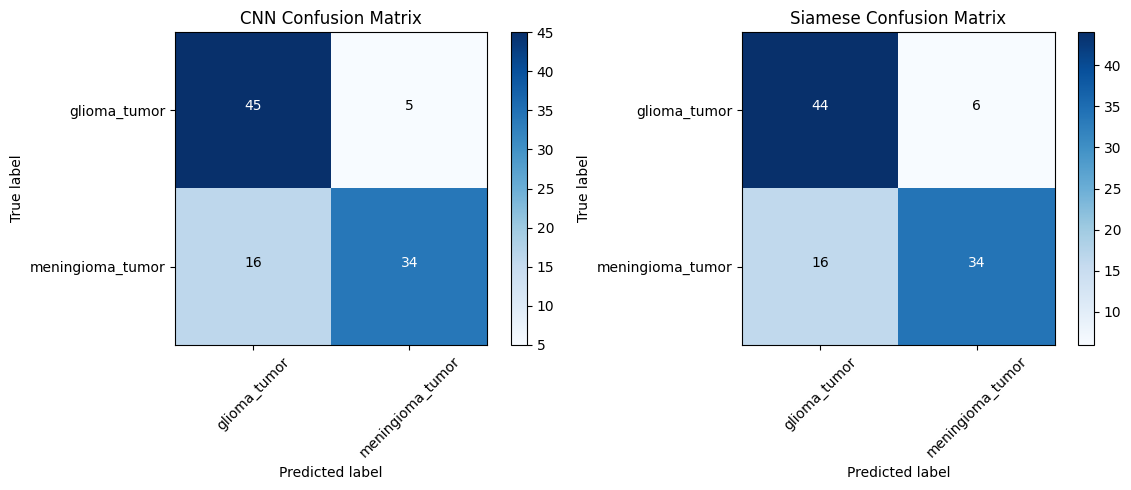

In [ ]:
def build_siamese_network(input_shape):
    # Load pre-trained DenseNet121 with ImageNet weights
    base_model = DenseNet121(
        weights='imagenet',
        include_top=False,
        input_shape=input_shape
    )

    # Freeze the pre-trained layers except for the last 20 layers
    for layer in base_model.layers[:-20]:
        layer.trainable = False

    # Add custom layers on top of DenseNet121
    input = keras.layers.Input(input_shape)
    x = base_model(input)

    # Global pooling to reduce dimensions
    x = keras.layers.GlobalAveragePooling2D()(x)

    # Additional dense layers for feature extraction
    x = keras.layers.Dense(512, activation="relu")(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Dropout(0.2)(x)
    x = keras.layers.Dense(128, activation="relu")(x)

    return keras.Model(input, x)

# Euclidean Distance Function
def euclidean_distance(vects):
    x, y = vects
    sum_square = tf.reduce_sum(tf.square(x - y), axis=1, keepdims=True)
    return tf.sqrt(tf.maximum(sum_square, keras.backend.epsilon()))

# Define contrastive loss function
def contrastive_loss(margin=1.0):
    def loss(y_true, y_pred):
        square_pred = tf.square(y_pred)
        margin_square = tf.square(tf.maximum(margin - y_pred, 0))
        return tf.reduce_mean((1 - y_true) * square_pred + (y_true) * margin_square)
    return loss

def compute_contrastive_accuracy(y_true, y_pred, threshold=0.5):
    return tf.keras.metrics.binary_accuracy(y_true, tf.cast(y_pred > threshold, tf.float32))

# Function to create imbalanced datasets for training, validation, and testing
def create_imbalanced_datasets(base_dir, target_size=(224, 224), batch_size=32):
    """
    Creates imbalanced datasets for train, validation, and test sets with the same ratio.
    - Training: 20 samples from class 0, 1000 samples from class 1
    - Validation: 4 samples from class 0, 200 samples from class 1 (5x smaller)
    - Testing: 4 samples from class 0, 200 samples from class 1 (5x smaller)
    """
    classes = ["glioma_tumor", "meningioma_tumor"]

    # Define the imbalance ratios
    train_imbalance = {
        classes[0]: 20,   # 20 images for first class
        classes[1]: 1000  # 1000 images for second class
    }

    # Validation and test sets are 5 times smaller but maintain the same ratio
    val_test_imbalance = {
        classes[0]: train_imbalance[classes[0]] // 5,  # 4 images
        classes[1]: train_imbalance[classes[1]] // 5   # 200 images
    }

    # First, collect all source image paths
    class_images = {}
    for split in ["Training", "Validation", "Testing"]:
        class_images[split] = {}
        for cls in classes:
            class_path = os.path.join(base_dir, split, cls)
            class_images[split][cls] = []
            for img_name in os.listdir(class_path):
                if img_name.lower().endswith(('.jpg', '.jpeg', '.png')):
                    class_images[split][cls].append(os.path.join(class_path, img_name))
            print(f"Found {len(class_images[split][cls])} original images for {split} - class '{cls}'")

    # Create imbalanced dataset directory structure
    imbalanced_dir = "./imbalanced_dataset"
    os.makedirs(imbalanced_dir, exist_ok=True)

    # Create split directories
    for split in ["Training", "Validation", "Testing"]:
        for cls in classes:
            os.makedirs(os.path.join(imbalanced_dir, split, cls), exist_ok=True)

    # Create imbalanced splits for each set
    for split in ["Training", "Validation", "Testing"]:
        # Determine which imbalance ratio to use
        if split == "Training":
            imbalance = train_imbalance
        else:
            imbalance = val_test_imbalance

        # Select and copy images for each class in this split
        for cls in classes:
            # Determine how many images to use (limited by available images)
            count = min(imbalance[cls], len(class_images[split][cls]))

            # Randomly select images
            selected_images = random.sample(class_images[split][cls], count)

            # Copy selected images to imbalanced dataset
            for img_path in selected_images:
                img_name = os.path.basename(img_path)
                dest_path = os.path.join(imbalanced_dir, split, cls, img_name)
                shutil.copy(img_path, dest_path)

            print(f"Created imbalanced {split} set: {count} images from '{cls}'")

    # Create data generators for CNN
    datagen = ImageDataGenerator(rescale=1./255)

    # Create generators for CNN
    train_generator = datagen.flow_from_directory(
        os.path.join(imbalanced_dir, "Training"),
        target_size=target_size,
        batch_size=batch_size,
        class_mode='binary',
        shuffle=True
    )

    val_generator = datagen.flow_from_directory(
        os.path.join(imbalanced_dir, "Validation"),
        target_size=target_size,
        batch_size=batch_size,
        class_mode='binary',
        shuffle=False
    )

    test_generator = datagen.flow_from_directory(
        os.path.join(imbalanced_dir, "Testing"),
        target_size=target_size,
        batch_size=batch_size,
        class_mode='binary',
        shuffle=False
    )

    # Create additional generators for SNN to ensure we're loading fresh data
    train_datagen_snn = ImageDataGenerator(rescale=1./255)
    val_datagen_snn = ImageDataGenerator(rescale=1./255)
    test_datagen_snn = ImageDataGenerator(rescale=1./255)

    train_base_snn = train_datagen_snn.flow_from_directory(
        os.path.join(imbalanced_dir, "Training"),
        target_size=target_size,
        batch_size=batch_size,
        class_mode='binary',
        shuffle=True
    )

    val_base_snn = val_datagen_snn.flow_from_directory(
        os.path.join(imbalanced_dir, "Validation"),
        target_size=target_size,
        batch_size=batch_size,
        class_mode='binary',
        shuffle=False
    )

    test_base_snn = test_datagen_snn.flow_from_directory(
        os.path.join(imbalanced_dir, "Testing"),
        target_size=target_size,
        batch_size=batch_size,
        class_mode='binary',
        shuffle=False
    )

    # Create Siamese pair generators from the imbalanced data
    train_pair_gen = SiamesePairGenerator(train_base_snn, batch_size=batch_size)
    val_pair_gen = SiamesePairGenerator(val_base_snn, batch_size=batch_size)
    test_pair_gen = SiamesePairGenerator(test_base_snn, batch_size=batch_size)

    return {
        'cnn': {
            'train': train_generator,
            'val': val_generator,
            'test': test_generator
        },
        'snn': {
            'train': train_pair_gen,
            'val': val_pair_gen,
            'test': test_pair_gen
        },
        'imbalanced_dir': imbalanced_dir
    }


# =============== CNN CLASSIFIER IMPLEMENTATION ===============

# Build CNN classifier with the same backbone as Siamese network
def build_cnn_classifier(input_shape, num_classes=2):
    # Use the same DenseNet121 base as the Siamese network
    base_model = DenseNet121(
        include_top=False,
        weights='imagenet',
        input_shape=input_shape,
        pooling='avg'
    )

    # Freeze the base model layers (same approach as in Siamese)
    base_model.trainable = False

    # Build the model
    inputs = keras.Input(shape=input_shape)
    x = base_model(inputs, training=False)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)

    # Use the same intermediate layer size as in Siamese for fair comparison
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.2)(x)

    # Output layer - binary classification
    outputs = Dense(num_classes, activation='softmax')(x)

    # Create the model
    model = Model(inputs=inputs, outputs=outputs)
    return model

# Function to evaluate CNN on test set
def evaluate_cnn(model, test_generator):
    # Get predictions
    y_pred = model.predict(test_generator)
    y_pred_classes = np.argmax(y_pred, axis=1)

    # Get ground truth
    test_generator.reset()
    y_true = []
    for i in range(len(test_generator)):
        _, batch_y = next(test_generator)
        batch_y_classes = np.argmax(batch_y, axis=1)
        y_true.extend(batch_y_classes)
    y_true = np.array(y_true[:len(y_pred_classes)])

    # Calculate metrics
    accuracy = np.mean(y_pred_classes == y_true)
    cm = confusion_matrix(y_true, y_pred_classes)
    report = classification_report(y_true, y_pred_classes, target_names=classes, output_dict=True)

    return accuracy, cm, report

# Function to evaluate Siamese network on test data using nearest neighbor
def evaluate_siamese(embedding_model, test_generator, train_generator):
    # Get embeddings and labels for training set (reference set)
    train_embeddings = []
    train_labels = []

    train_generator.reset()
    for i in range(len(train_generator)):
        batch_x, batch_y = next(train_generator)
        batch_embeddings = embedding_model.predict(batch_x, verbose=0)
        batch_labels = np.argmax(batch_y, axis=1)

        train_embeddings.append(batch_embeddings)
        train_labels.append(batch_labels)

    train_embeddings = np.vstack(train_embeddings)
    train_labels = np.concatenate(train_labels)

    # Get embeddings and labels for test set
    test_embeddings = []
    test_labels = []

    test_generator.reset()
    for i in range(len(test_generator)):
        batch_x, batch_y = next(test_generator)
        batch_embeddings = embedding_model.predict(batch_x, verbose=0)
        batch_labels = np.argmax(batch_y, axis=1)

        test_embeddings.append(batch_embeddings)
        test_labels.append(batch_labels)

    test_embeddings = np.vstack(test_embeddings)
    test_labels = np.concatenate(test_labels)

    # For each test embedding, find the nearest training embedding
    predictions = []
    for test_embed in test_embeddings:
        # Calculate distances to all training embeddings
        distances = np.sqrt(np.sum((train_embeddings - test_embed)**2, axis=1))
        # Find the nearest
        nearest_idx = np.argmin(distances)
        # Use the label of the nearest neighbor
        predictions.append(train_labels[nearest_idx])

    # Calculate metrics
    predictions = np.array(predictions)
    accuracy = np.mean(predictions == test_labels)
    cm = confusion_matrix(test_labels, predictions)
    report = classification_report(test_labels, predictions, target_names=classes, output_dict=True)

    return accuracy, cm, report

# Function to plot training history
def plot_training_history(history, title="Training History"):
    plt.figure(figsize=(12, 5))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    if 'accuracy' in history.history:
        plt.plot(history.history['accuracy'], label='Training Accuracy')
    if 'val_accuracy' in history.history:
        plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{title} - Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.grid(True, alpha=0.3)

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{title} - Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

# =============== MAIN TRAINING AND EVALUATION CODE ===============

def run_comparison():
    # Set paths
    train_dir = os.path.join(output_dir, 'Training')
    val_dir = os.path.join(output_dir, 'Validation')
    test_dir = os.path.join(output_dir, 'Testing')

    # Set parameters
    img_size = (150, 150)
    batch_size = 32
    num_classes = len(classes)
    num_epochs = 30
    input_shape = img_size + (3,)

    # Check directories exist
    for directory in [train_dir, val_dir, test_dir]:
        if not os.path.exists(directory):
            raise ValueError(f"Directory does not exist: {directory}")

    # Set up data generators
    # For CNN
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    val_test_datagen = ImageDataGenerator(rescale=1./255)

    # Set up standard data generators
    print("\nCreating data generators...")

    # For CNN
    cnn_train_gen = train_datagen.flow_from_directory(
        train_dir,
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True
    )

    cnn_val_gen = val_test_datagen.flow_from_directory(
        val_dir,
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False
    )

    cnn_test_gen = val_test_datagen.flow_from_directory(
        test_dir,
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False
    )

    # Base generators for Siamese network with larger batch sizes
    base_train = val_test_datagen.flow_from_directory(
        train_dir,
        target_size=img_size,
        batch_size=split_counts['Training'] * num_classes,  # Load all images at once
        class_mode='categorical',
        shuffle=True
    )

    base_val = val_test_datagen.flow_from_directory(
        val_dir,
        target_size=img_size,
        batch_size=split_counts['Validation'] * num_classes,  # Load all images at once
        class_mode='categorical',
        shuffle=False
    )

    base_test = val_test_datagen.flow_from_directory(
        test_dir,
        target_size=img_size,
        batch_size=split_counts['Testing'] * num_classes,  # Load all images at once
        class_mode='categorical',
        shuffle=False
    )

    # Siamese generators
    print("\nCreating Siamese pair generators...")
    train_gen = SiamesePairGenerator(base_train, batch_size=batch_size)
    val_gen = SiamesePairGenerator(base_val, batch_size=batch_size)
    test_gen = SiamesePairGenerator(base_test, batch_size=batch_size)

    # Example usage: one batch
    (train_left, train_right), train_labels = train_gen[0]
    (val_left, val_right), val_labels = val_gen[0]

    # Visualize some pairs
    print("\nVisualizing training and validation pairs...")
    visualize(train_left, train_right, train_labels, title='Train')
    visualize(val_left, val_right, val_labels, title='Validation')

    # Create models
    print("\nBuilding models...")

    # 1. CNN Classifier
    cnn_model = build_cnn_classifier(input_shape, num_classes)
    cnn_model.compile(
        optimizer=Adam(learning_rate=1e-3),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    cnn_model.summary()

    # 2. Siamese Network
    embedding_network = build_siamese_network(input_shape)

    # Create Siamese model
    input_1 = keras.layers.Input(input_shape)
    input_2 = keras.layers.Input(input_shape)

    tower_1 = embedding_network(input_1)
    tower_2 = embedding_network(input_2)

    merge_layer = keras.layers.Lambda(euclidean_distance, output_shape=(1,))([tower_1, tower_2])
    normal_layer = keras.layers.BatchNormalization()(merge_layer)
    output_layer = keras.layers.Dense(1, activation="sigmoid")(normal_layer)

    siamese_network = keras.Model(inputs=[input_1, input_2], outputs=output_layer)

    # Compile the SNN model
    siamese_network.compile(
        loss=contrastive_loss(margin=1.5),
        optimizer=keras.optimizers.Adam(learning_rate=1e-3),
        metrics=[compute_contrastive_accuracy]
    )

    # Print SNN model summary
    siamese_network.summary()


    # Train both models
    results = {}

    # 1. Train CNN
    print("\n--- Training CNN Classifier ---")
    cnn_start_time = time.time()

    cnn_history = cnn_model.fit(
        cnn_train_gen,
        validation_data=cnn_val_gen,
        epochs=num_epochs,
        callbacks=[
            tf.keras.callbacks.EarlyStopping(
                monitor='val_loss',
                patience=5,
                restore_best_weights=True
            )
        ]
    )

    cnn_training_time = time.time() - cnn_start_time

    # Plot CNN training history
    plot_training_history(cnn_history, "CNN Classifier")

    # 2. Train Siamese Network
    print("\n--- Training Siamese Network ---")
    siamese_start_time = time.time()

    # Create callbacks for SNN
    distance_logger = DistanceLogger(validation_generator=train_pair_gen)
    embedding_visualizer = EmbeddingVisualizer(
        validation_generator=val_pair_gen,
        embedding_network=embedding_network,
        num_samples=200,
        class_names=["glioma_tumor", "meningioma_tumor"]
    )

    snn_callbacks = [
        tf.keras.callbacks.ModelCheckpoint('siamese_model_imbalanced.h5', save_best_only=True),
        tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True),
        distance_logger,
        embedding_visualizer
    ]

    # Train the SNN model
    print("\n--- Training SNN with pairs from the imbalanced data ---")
    snn_history = siamese_network.fit(
        train_pair_gen,
        epochs=30,
        validation_data=val_pair_gen,
        callbacks=snn_callbacks,
        verbose=1
    )
    siamese_training_time = time.time() - siamese_start_time

    # Plot Siamese training history
    plot_training_history(siamese_history, "Siamese Network")

    # Calculate distances
    similar_dist, dissimilar_dist = calculate_distances(siamese_network, test_gen)
    print(f"\nTest Set - Avg distance (same class): {similar_dist:.4f}")
    print(f"Test Set - Avg distance (different class): {dissimilar_dist:.4f}")
    print(f"Distance gap: {dissimilar_dist - similar_dist:.4f}")

    # Evaluate both models
    print("\n--- Evaluating CNN Classifier ---")
    cnn_test_start = time.time()
    cnn_acc, cnn_cm, cnn_report = evaluate_cnn(cnn_model, cnn_test_gen)
    cnn_inference_time = time.time() - cnn_test_start

    print("\n--- Evaluating Siamese Network ---")
    siamese_test_start = time.time()
    siamese_acc, siamese_cm, siamese_report = evaluate_siamese(
        embedding_network, cnn_test_gen, cnn_train_gen
    )
    siamese_inference_time = time.time() - siamese_test_start

    # Store results
    results = {
        "CNN": {
            "accuracy": cnn_acc,
            "training_time": cnn_training_time,
            "inference_time": cnn_inference_time,
            "report": cnn_report,
            "confusion_matrix": cnn_cm
        },
        "Siamese": {
            "accuracy": siamese_acc,
            "training_time": siamese_training_time,
            "inference_time": siamese_inference_time,
            "report": siamese_report,
            "confusion_matrix": siamese_cm,
            "similar_dist": similar_dist,
            "dissimilar_dist": dissimilar_dist
        }
    }

    # Display results
    print("\n" + "=" * 50)
    print("RESULTS COMPARISON")
    print("=" * 50)

    print(f"\nTest Accuracy:")
    print(f"  CNN Classifier: {results['CNN']['accuracy']:.4f}")
    print(f"  Siamese Network: {results['Siamese']['accuracy']:.4f}")

    print(f"\nTraining Time:")
    print(f"  CNN Classifier: {results['CNN']['training_time']:.2f} seconds")
    print(f"  Siamese Network: {results['Siamese']['training_time']:.2f} seconds")

    print(f"\nInference Time:")
    print(f"  CNN Classifier: {results['CNN']['inference_time']:.2f} seconds")
    print(f"  Siamese Network: {results['Siamese']['inference_time']:.2f} seconds")

    # Print detailed metrics
    for model_name in ["CNN", "Siamese"]:
        print(f"\n{model_name} Classifier Report:")
        for class_name in classes:
            if class_name in results[model_name]["report"]:
                metrics = results[model_name]["report"][class_name]
                print(f"  {class_name}:")
                print(f"    Precision: {metrics['precision']:.4f}")
                print(f"    Recall: {metrics['recall']:.4f}")
                print(f"    F1-score: {metrics['f1-score']:.4f}")

    # Plot confusion matrices
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(results["CNN"]["confusion_matrix"], interpolation='nearest', cmap='Blues')
    plt.title('CNN Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    # Add text annotations
    thresh = results["CNN"]["confusion_matrix"].max() / 2.
    for i in range(len(classes)):
        for j in range(len(classes)):
            plt.text(j, i, format(results["CNN"]["confusion_matrix"][i, j], 'd'),
                    horizontalalignment="center",
                    color="white" if results["CNN"]["confusion_matrix"][i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    plt.subplot(1, 2, 2)
    plt.imshow(results["Siamese"]["confusion_matrix"], interpolation='nearest', cmap='Blues')
    plt.title('Siamese Confusion Matrix')
    plt.colorbar()
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    # Add text annotations
    thresh = results["Siamese"]["confusion_matrix"].max() / 2.
    for i in range(len(classes)):
        for j in range(len(classes)):
            plt.text(j, i, format(results["Siamese"]["confusion_matrix"][i, j], 'd'),
                    horizontalalignment="center",
                    color="white" if results["Siamese"]["confusion_matrix"][i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    plt.show()

    return results

# Run the comparison if this script is executed directly
if __name__ == "__main__":
    # Seed for reproducibility
    np.random.seed(42)
    tf.random.set_seed(42)
    random.seed(42)

    # Run comparison
    results = run_comparison()